In [1]:
%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy.io import fits
from astropy import units as u
import PIL
import regions
import pyavm
import numpy as np
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (10,8)
pl.rcParams['figure.dpi'] = 100
pl.rcParams['font.size'] = 16

In [2]:
from astroquery.vizier import Vizier

In [3]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [4]:
import sys, imp
sys.path.append(f'{basepath}/analysis/')
sys.path.append(f'{basepath}/reduction/')
import plot_tools
imp.reload(plot_tools)
from plot_tools import starzoom, make_sed

/orange/adamginsburg/jwst/brick//reduction/filtering.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
from plot_tools import starzoom, make_sed

In [6]:
basetable = Table.read(f'{basepath}/catalogs/crowdsource_nsky0_merged_photometry_tables_merged.fits')
len(basetable)

550107

### DEbug

#maskf405n = basetable['mag_ab_f405n'].mask.copy()
#basetable['mag_ab_f405n'].mask[:] = False
maskf405n = np.isnan(basetable['mag_ab_f405n'])
basetable['mag_ab_f405n'][maskf405n]
flux = basetable['flux_f405n']
fwhm_arcsec = 0.136*u.arcsec
pxdg = u.Quantity(basetable.meta['405pxdg'], u.deg**2)
fwhm_pix = basetable['fwhm_f405n']
flux_jy = (u.Quantity(flux, u.MJy/u.sr) * (2*np.pi / (8*np.log(2))) * fwhm_pix**2 * pxdg).to(u.Jy)
abmag = flux_jy.to(u.ABmag)
abmag[maskf405n], flux_jy[maskf405n]

In [7]:
filternames = ['f410m', 'f212n', 'f466n', 'f405n', 'f187n', 'f182m']

In [8]:
any_saturated_ = [basetable[x] for x in basetable.colnames if 'near_sat' in x]
any_saturated = any_saturated_[0]
for row in any_saturated_[1:]:
    #print(row.sum())
    any_saturated = any_saturated | row
magerr_gtpt1 = np.logical_or.reduce([basetable[f'emag_ab_{filtername}'] > 0.2 for filtername in filternames])

In [9]:
oksep = np.logical_or.reduce([basetable[f'sep_{filtername}'] for filtername in filternames[1:]])
blue_410_466 = oksep & ~any_saturated & (~(basetable['mag_ab_410m405'].mask)) & ((basetable['mag_ab_410m405'] - basetable['mag_ab_f466n']) + (basetable['emag_ab_f410m']**2 + basetable['emag_ab_f466n']**2 + basetable['emag_ab_f405n']**2)**0.5 < -1.75)
assert (blue_410_466 & basetable['mag_ab_410m405'].mask).sum() == 0
blue_410_405 = oksep & ~any_saturated & (~(basetable['mag_ab_410m405'].mask)) & ((basetable['mag_ab_410m405'] - basetable['mag_ab_f405n']) + (basetable['emag_ab_f410m']**2 + basetable['emag_ab_f405n']**2)**0.5 < -2)
blue_405_410 = oksep & ~any_saturated & (~(basetable['mag_ab_410m405'].mask)) & ((basetable['mag_ab_405m410'] - basetable['mag_ab_410m405']) + (basetable['emag_ab_f410m']**2 + basetable['emag_ab_f405n']**2)**0.5 < -3)
blue_405_410b = oksep & ~any_saturated & (basetable['flux_f405n'] > basetable['flux_f410m']) & (~(basetable['mag_ab_f405n'].mask)) & ((basetable['mag_ab_f405n'] - basetable['mag_ab_f410m']) + (basetable['emag_ab_f410m']**2 + basetable['emag_ab_f405n']**2)**0.5 < -2) & ~magerr_gtpt1

In [10]:
blue_410_466.sum(), blue_405_410.sum(), blue_405_410b.sum()

(466, 57, 63)

In [11]:
viz = Vizier()

In [12]:
bluetbl = basetable[blue_410_466]
bluetbl.sort('flux_f410m')
bluetbl[-5:]

<Table length=5>
             skycoord_ref             sep_f410m id_f410m             skycoord_f410m                 x_f410m            y_f410m       ... flux_jy_405m410 mag_ab_405m410 flux_jy_182m187 mag_ab_182m187 flux_jy_187m182 mag_ab_187m182
               deg,deg                   deg                            deg,deg                                                      ...        Jy                             Jy                             Jy                     
               SkyCoord                float64   int64                  SkyCoord                    float64            float64       ...     float32        float32         float32        float32         float32        float32    
------------------------------------- --------- -------- ------------------------------------- ------------------ ------------------ ... --------------- -------------- --------------- -------------- --------------- --------------
266.5359641170909,-28.716991709440904       0.0    63796 266.5359641170909,-28.716991709440904   2597.85705509258 1180.4166581010445 ...    0.0013158093      16.102016    3.509188e-05      20.036983   1.1033808e-05      21.293186
266.5491681749946,-28.721830778282385       0.0    99714 266.5491681749946,-28.721830778282385 2311.2132265156374 1837.7934652126503 ...   0.00079452153      16.649736   3.8807844e-05        19.9277   1.2975237e-05      21.117212
266.54338359560523,-28.69739582138272       0.0    85075 266.54338359560523,-28.69739582138272 3711.7915484329137  1569.394296109451 ...     0.003179825      15.143991   3.3723576e-05      20.080166  1.30123335e-05       21.11411
266.54556276943896,-28.72537761864832       0.0    89761 266.54556276943896,-28.72537761864832  2111.341387982768 1654.0235752331891 ...     0.002174138      15.556783   2.3724848e-05       20.46199    6.950193e-06      21.795008
266.5554043694086,-28.760193621890682       0.0   114520 266.5554043694086,-28.760193621890682  114.4880156815052   2116.37684828043 ...    -0.052203223             --   0.00015775711      18.405027   -1.972307e-05             --

In [13]:
fov = regions.Regions.read(f'{basepath}/regions/nircam_fov.reg')

In [14]:
coord = fov[0].center
height = fov[0].height
width = fov[0].width
height, width = width, height # CARTA wrote it wrong
coord, width, height

(<SkyCoord (ICRS): (ra, dec) in deg
     (266.53496367, -28.71007499)>,
 <Quantity 161.9038 arcsec>,
 <Quantity 391.024 arcsec>)

In [15]:
skycrds_cat = bluetbl['skycoord_f410m']

In [16]:
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
wwi_spitzer_unflip = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [17]:
spitzer = Vizier(row_limit=1e6).query_region(coordinates=coord, width=width*2, height=height*2, catalog=['II/295/SSTGC'])[0]
spitzer.add_index('SSTGC')
spitzer_crds = SkyCoord(spitzer['RAJ2000'], spitzer['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
spitzer.add_column(col=spitzer_crds, name='coordinates')
assert len(spitzer) > 1
spitzer.write('/orange/adamginsburg/spitzer/cmz_catalog_II_295_SSTGC_Ramirez2008.fits', overwrite=True)

spitzer_crds_in_field = wwi_spitzer_unflip.footprint_contains(spitzer_crds)
spitzer = spitzer[spitzer_crds_in_field]
spitzer_crds = spitzer_crds[spitzer_crds_in_field]
idx, sidx, sep, sep3d = spitzer_crds.search_around_sky(skycrds_cat, 1*u.arcsec)
len(spitzer), len(idx), len(sidx)

(1169, 34, 34)

/scratch/local/56668455/ipykernel_15736/1515990771.py:1: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  pl.scatter(spitzer_crds.ra[sidx], spitzer_crds.dec[sidx], facecolor='b', edgecolor='b', marker='x')


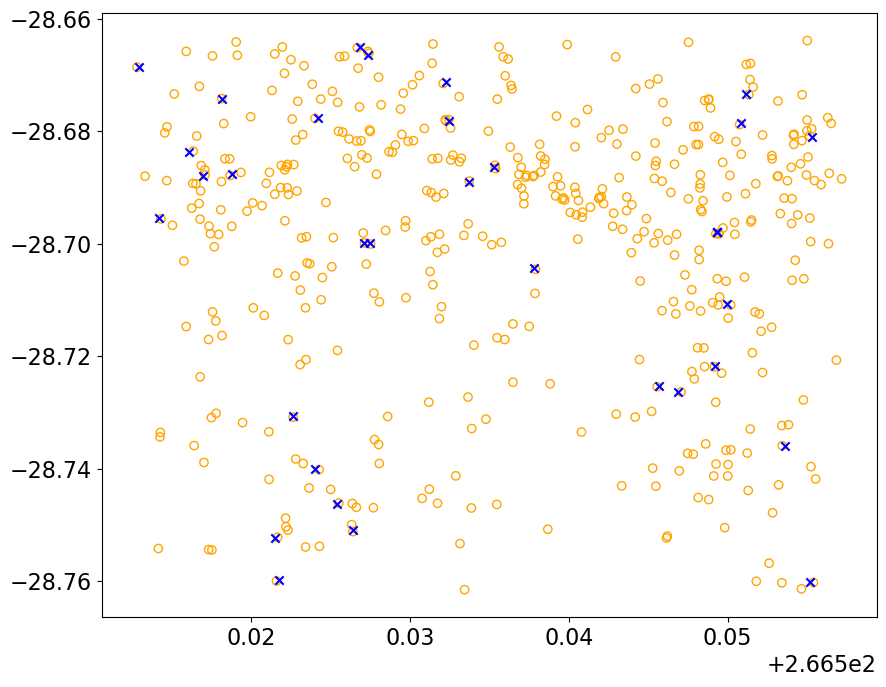

In [18]:
pl.scatter(spitzer_crds.ra[sidx], spitzer_crds.dec[sidx], facecolor='b', edgecolor='b', marker='x')
pl.scatter(skycrds_cat.ra, skycrds_cat.dec, facecolor='none', edgecolor='orange', zorder=-5)

Set OBSGEO-B to   -20.631897 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526059356.900 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


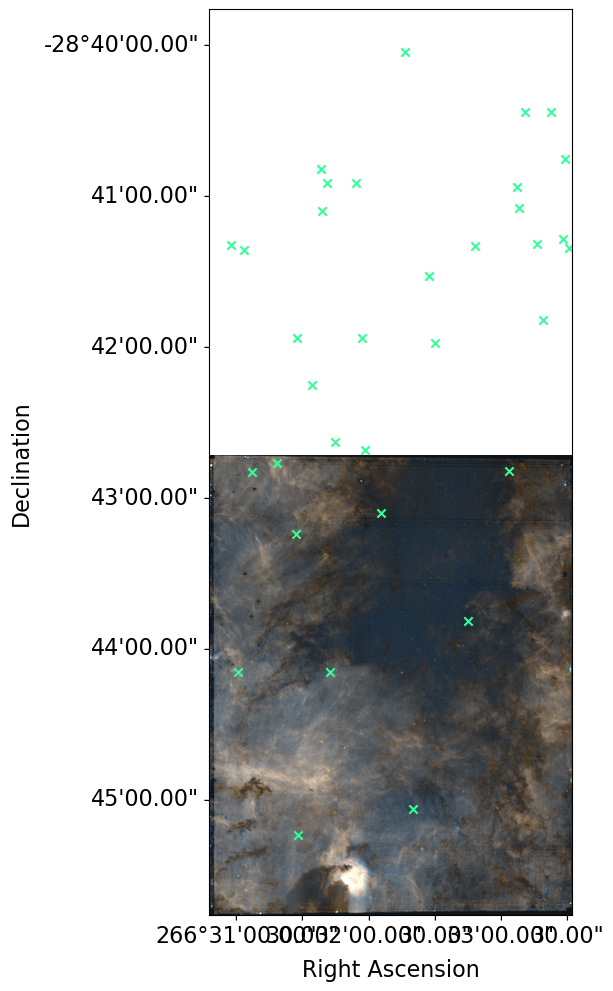

In [19]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_nrca_longwave_narrowband_rotated_lighter.png')
img_narrow = np.array(PIL.Image.open(f'{basepath}/images/BrickJWST_nrca_longwave_narrowband_rotated_lighter.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_narrow = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_narrow = img_narrow.swapaxes(0,1)
wwi_narrow = wwi_narrow.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_narrow)
ax.imshow(img_narrow)

crds = basetable['skycoord_f410m']
ax.scatter(
    crds.dec[blue_410_466][idx],
    crds.ra[blue_410_466][idx],
    transform=ax.get_transform('world'),
    marker='x', facecolors=(0.2, 1, 0.6),
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), 
);
#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('dd:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
#lon.set_ticks(spacing=30. * u.arcsec, color='red')
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')
#lon.set_ticklabel(color='red')
#lat.set_ticklabel(color='blue')
#lon.grid(color='red')
#lat.grid(color='blue')

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


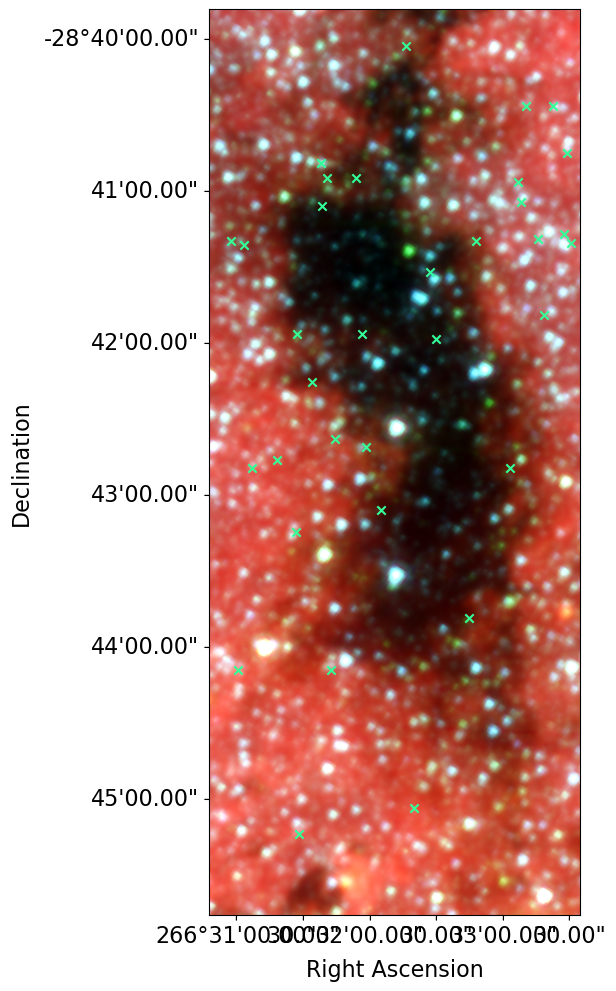

In [20]:
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
img_spitzer = np.array(PIL.Image.open(f'{basepath}/images/BrickSpitzer_RGB_I421.png'))[::-1,:,:]
wwi_spitzer_unflip = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_spitzer = img_spitzer.swapaxes(0,1)
wwi_spitzer = wwi_spitzer_unflip.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_spitzer)
ax.imshow(img_spitzer)

crds = basetable['skycoord_f410m']
ax.scatter(
    crds.dec[blue_410_466][idx],
    crds.ra[blue_410_466][idx],
    transform=ax.get_transform('world'),
    marker='x', facecolors=(0.2, 1, 0.6),
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), 
);
#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('dd:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
#lon.set_ticks(spacing=30. * u.arcsec, color='red')
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')
#lon.set_ticklabel(color='red')
#lat.set_ticklabel(color='blue')
#lon.grid(color='red')
#lat.grid(color='blue')

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

In [21]:
spitzer[:3]

<Table length=3>
 SSTGC    RAJ2000     DEJ2000     Jmag    Hmag    Ksmag   _3.6mag _4.5mag _5.8mag _8.0mag IRAC _2M               coordinates             
          'h:m:s'     'd:m:s'     mag     mag      mag      mag     mag     mag     mag                            deg,deg               
  str7     str11       str11    float32 float32  float32  float32 float32 float32 float32 str4 str2                SkyCoord              
------- ----------- ----------- ------- -------- -------- ------- ------- ------- ------- ---- ---- -------------------------------------
0587868 17 46 02.85 -28 40 12.2  16.356   12.092   10.268   8.880   8.877   8.521   8.613 IRAC   2M        266.511875,-28.670055555555557
0587987 17 46 02.88 -28 40 56.9      --       --       --  11.862  11.750  11.650      -- IRAC   2M           266.512,-28.682472222222223
0588048 17 46 02.91 -28 41 10.7  16.354   13.242   11.082   9.990   9.987   9.204   8.947 IRAC   2M 266.5121249999999,-28.686305555555556

Text(0, 0.5, 'I2-I4')

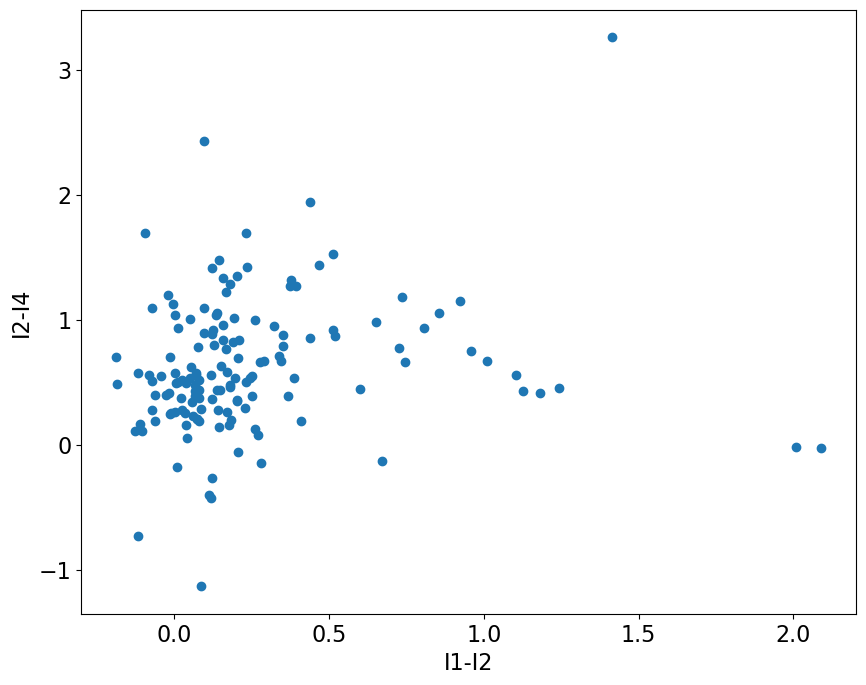

In [22]:
pl.scatter(spitzer['_3.6mag'] - spitzer['_4.5mag'],  spitzer['_4.5mag'] - spitzer['_8.0mag'])
pl.xlabel("I1-I2")
pl.ylabel("I2-I4")

Text(0, 0.5, 'I2')

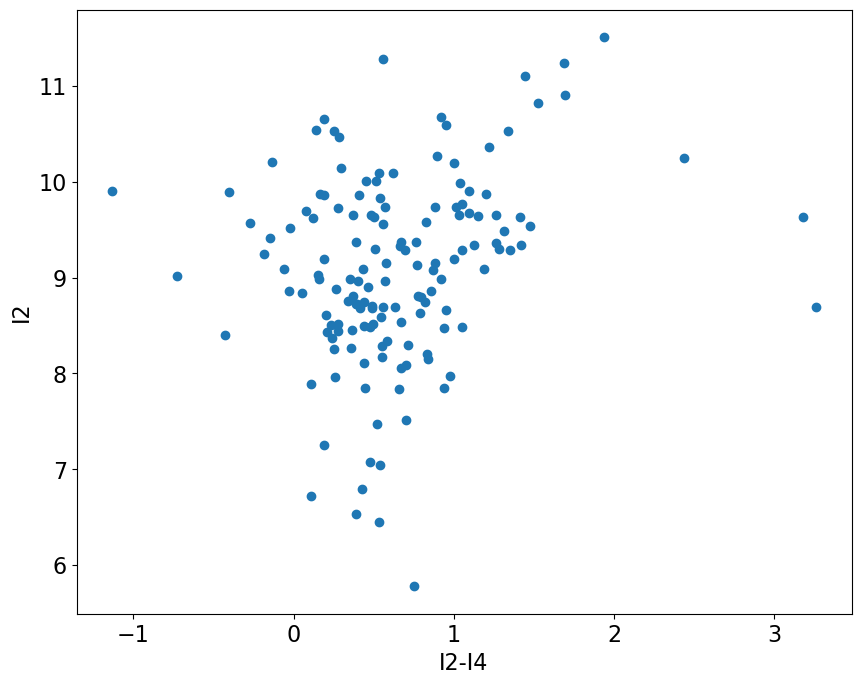

In [23]:
pl.scatter(spitzer['_4.5mag'] - spitzer['_8.0mag'],  spitzer['_4.5mag'])
pl.xlabel("I2-I4")
pl.ylabel("I2")

Text(0, 0.5, 'I2-I4')

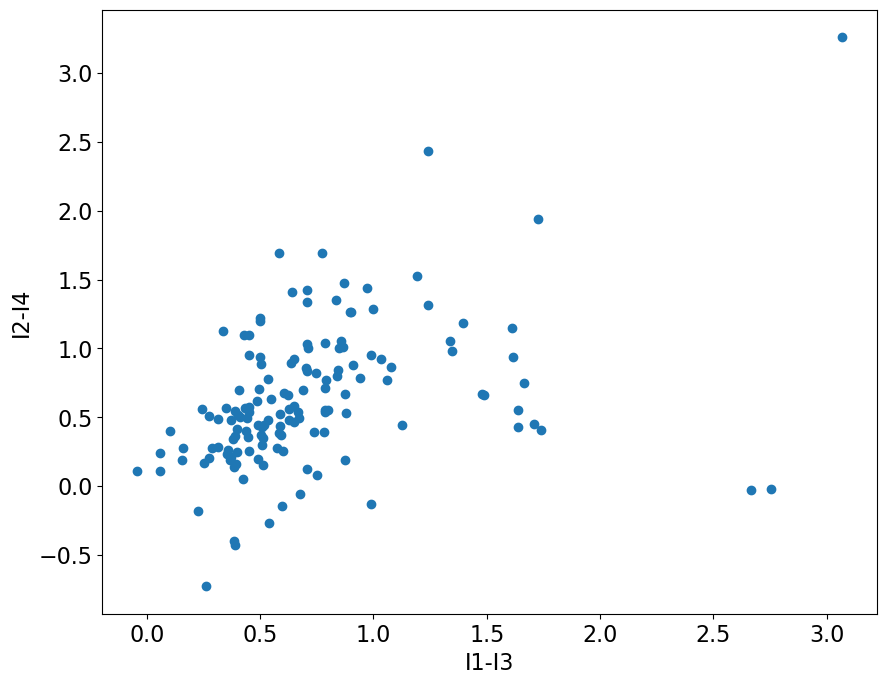

In [24]:
pl.scatter(spitzer['_3.6mag'] - spitzer['_5.8mag'],  spitzer['_4.5mag'] - spitzer['_8.0mag'])
pl.xlabel("I1-I3")
pl.ylabel("I2-I4")

In [25]:
wwi_spitzer.world_to_pixel(spitzer_crds[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0])

(array([  6.94763763,  26.45448607,  20.32406318,  40.98150225,
        196.08575698, 277.73480409, 315.53324653, 398.56227853,
        446.52683274, 463.78622616, 515.68907643]),
 array([ 662.57186034,  778.95768184,  199.61880154, 1326.42026218,
         156.87255305,  137.76951954, 1040.47277236,  767.74140476,
         287.58311956,   52.36904822, 1117.56988696]))

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


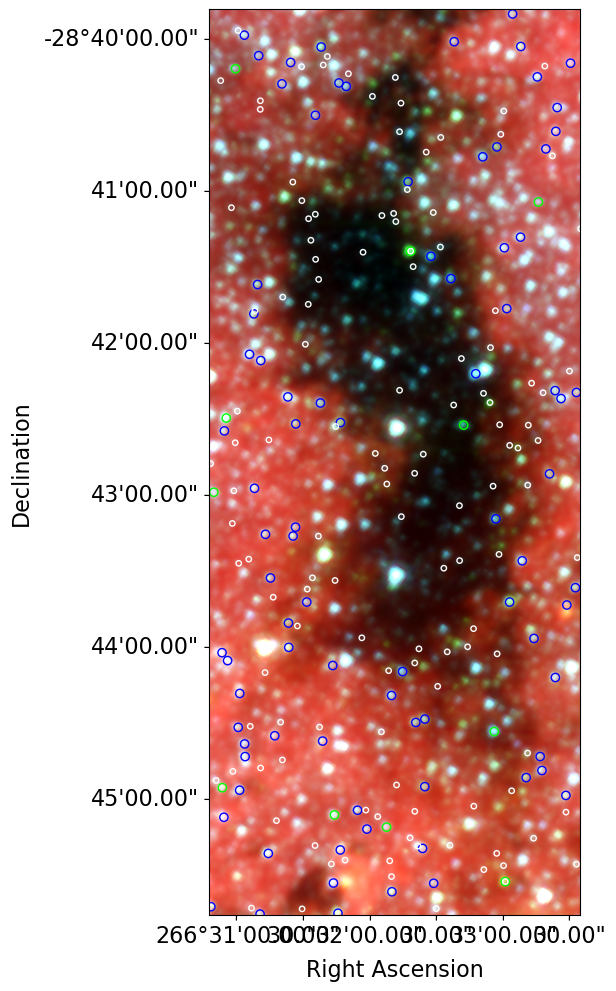

In [26]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
img_spitzer = np.array(PIL.Image.open(f'{basepath}/images/BrickSpitzer_RGB_I421.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_spitzer_unflip = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_spitzer = img_spitzer.swapaxes(0,1)
wwi_spitzer = wwi_spitzer_unflip.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_spitzer)
ax.imshow(img_spitzer)
axlims = ax.axis()

green_spitzer = (spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0.)
green_nored = ((spitzer['_4.5mag'] < 10) & (spitzer['_8.0mag'].mask))
xx,yy = wwi_spitzer.world_to_pixel(spitzer_crds[green_spitzer])
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='lime', facecolors='none',
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);
xx,yy = wwi_spitzer.world_to_pixel(spitzer_crds[green_nored])
ax.scatter(
    xx,yy,
    marker='o', edgecolors='b', facecolors='none',
);
redi1i2_spitzer = (spitzer['_3.6mag'] - spitzer['_4.5mag'] > 1.75)# | ((10 < spitzer['_4.5mag']) & (spitzer['_4.5mag'] < 15) & (spitzer['_8.0mag'].mask))
xx,yy = wwi_spitzer.world_to_pixel(spitzer_crds[redi1i2_spitzer])
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='w', facecolors='none',
s=15,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);
#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('dd:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
#lon.set_ticks(spacing=30. * u.arcsec, color='red')
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')
#lon.set_ticklabel(color='red')
#lat.set_ticklabel(color='blue')
#lon.grid(color='red')
#lat.grid(color='blue')

ax.axis(axlims)

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

In [27]:
coord = SkyCoord('17:46:08.914 -28:41:22.51', frame='fk5', unit=(u.hour, u.deg))
radius = 0.5*u.arcsec

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (266.53714167, -28.68958611)>

<Figure size 1200x400 with 0 Axes>

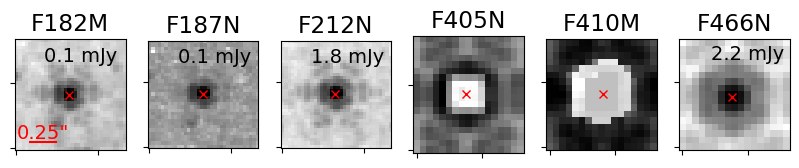

<Figure size 1200x400 with 0 Axes>

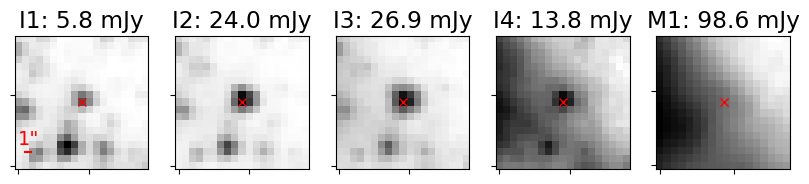

In [28]:
import sys, imp
sys.path.append(f'{basepath}/analysis/')
sys.path.append(f'{basepath}/reduction/')
import plot_tools
imp.reload(plot_tools)
from plot_tools import starzoom, make_sed, starzoom_spitzer
starzoom(coord)
starzoom_spitzer(coord)
coord

In [29]:
(coord.separation(skycrds_cat) < radius).sum()

0

In [30]:
coord = SkyCoord('17:46:08.914 -28:41:22.51', frame='fk5', unit=(u.hour, u.deg))
radius = 0.5*u.arcsec

skycrds_cat = basetable['skycoord_f410m']
idx = coord.separation(skycrds_cat) < radius
if len(idx) == 0:
    raise

spitzer_ = Vizier.query_region(coordinates=coord, radius=radius, catalog=['II/295/SSTGC'])[0]
if len(spitzer) > 0:
    spitzer_crds = SkyCoord(spitzer_['RAJ2000'], spitzer_['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
    spitzindex = coord.separation(spitzer_crds) < radius
    print(len(spitzindex))
    spitzermatch = spitzer_[spitzindex]

vvvdr2 = Vizier.query_region(coordinates=coord, radius=0.5*u.arcsec, catalog=['II/348/vvv2'])[0]
if len(spitzer) > 0:
    vvvdr2_crds = SkyCoord(vvvdr2['RAJ2000'], vvvdr2['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
    vvvindex = coord.separation(vvvdr2_crds) < radius
    print(len(vvvindex))
    vvvmatch = vvvdr2[vvvindex]

1
1


In [31]:
from astroquery.svo_fps import SvoFps

In [32]:
for filtername in filternames:
    telescope = 'JWST'
    instrument = 'NIRCAM'
    wavelength_table = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filtername}')

In [33]:
spitzer[:1]

<Table length=1>
 SSTGC    RAJ2000     DEJ2000     Jmag    Hmag    Ksmag   _3.6mag _4.5mag _5.8mag _8.0mag IRAC _2M           coordinates          
          'h:m:s'     'd:m:s'     mag     mag      mag      mag     mag     mag     mag                        deg,deg            
  str7     str11       str11    float32 float32  float32  float32 float32 float32 float32 str4 str2            SkyCoord           
------- ----------- ----------- ------- -------- -------- ------- ------- ------- ------- ---- ---- ------------------------------
0587868 17 46 02.85 -28 40 12.2  16.356   12.092   10.268   8.880   8.877   8.521   8.613 IRAC   2M 266.511875,-28.670055555555557

In [34]:
    skycrds_cat = basetable['skycoord_f410m']
    idx = coord.separation(skycrds_cat) < radius
    if len(idx) == 0:
        raise
    else:
        idx = np.argmin(coord.separation(skycrds_cat))

    spitzer_this = Vizier.query_region(coordinates=coord, radius=radius, catalog=['II/295/SSTGC'])[0]
    if len(spitzer) > 0:
        spitzer_crds = SkyCoord(spitzer_this['RAJ2000'], spitzer_this['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
        spitzindex = coord.separation(spitzer_crds) < radius
        print(len(spitzindex))
        spitzermatch = spitzer_this[spitzindex]

    vvvdr2 = Vizier.query_region(coordinates=coord, radius=0.5*u.arcsec, catalog=['II/348/vvv2'])[0]
    if len(spitzer) > 0:
        vvvdr2_crds = SkyCoord(vvvdr2['RAJ2000'], vvvdr2['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
        vvvindex = coord.separation(vvvdr2_crds) < radius
        print(len(vvvindex))
        vvvmatch = vvvdr2[vvvindex]

    wavelengths = []
    fluxes = []
    widths = []
    telescope = 'JWST'
    instrument = 'NIRCAM'
    filter_table = SvoFps.get_filter_list(facility=telescope, instrument=instrument)
    filter_table.add_index('filterID')
    for filtername in filternames:
        instrument = 'NIRCam'
        filtername = filtername.upper()
        eff_wavelength = filter_table.loc[f'{telescope}/{instrument}.{filtername}']['WavelengthEff'] * u.AA
        wavelengths.append(eff_wavelength)
        eff_width = filter_table.loc[f'{telescope}/{instrument}.{filtername}']['WidthEff'] * u.AA
        widths.append(eff_width)
        filtername = filtername.lower()
        fluxes.append(basetable[f'flux_jy_{filtername}'][idx] * u.Jy)


    telescope = 'Spitzer'
    instrument = 'IRAC'
    filter_table = SvoFps.get_filter_list(facility=telescope, instrument=instrument)
    filter_table.add_index('filterID')
    for filtername,colname in [('I1', '_3.6mag'),
                               ('I2', '_4.5mag'),
                               ('I3', '_5.8mag'),
                               ('I4', '_8.0mag')]:
        eff_wavelength = filter_table.loc[f'{telescope}/{instrument}.{filtername}']['WavelengthEff'] * u.AA
        wavelengths.append(eff_wavelength)
        fluxes.append(10**(-spitzermatch[colname][0]/2.5) * filter_table.loc[f'{telescope}/{instrument}.{filtername}']['ZeroPoint'] * u.Jy)
        eff_width = filter_table.loc[f'{telescope}/{instrument}.{filtername}']['WidthEff'] * u.AA
        widths.append(eff_width)


1
1


In [35]:
filternames

['f410m', 'f212n', 'f466n', 'f405n', 'f187n', 'f182m']

In [36]:
fluxes, widths

([<Quantity 0.13709076 Jy>,
  <Quantity 0.02641613 Jy>,
  <Quantity 0.04731302 Jy>,
  <Quantity -0.02961002 Jy>,
  <Quantity 0.00204861 Jy>,
  <Quantity 0.00167911 Jy>,
  <Quantity 0.01141275 Jy>,
  <Quantity 0.05058216 Jy>,
  <Quantity 0.05510747 Jy>,
  <Quantity 0.01762664 Jy>],
 [<Quantity 4262.85790239 Angstrom>,
  <Quantity 274.27440341 Angstrom>,
  <Quantity 535.40523943 Angstrom>,
  <Quantity 454.87184789 Angstrom>,
  <Quantity 236.68645057 Angstrom>,
  <Quantity 2250.8124937 Angstrom>,
  <Quantity 6836.18018646 Angstrom>,
  <Quantity 8649.92060205 Angstrom>,
  <Quantity 12561.17490202 Angstrom>,
  <Quantity 25288.49843082 Angstrom>])

<ErrorbarContainer object of 3 artists>

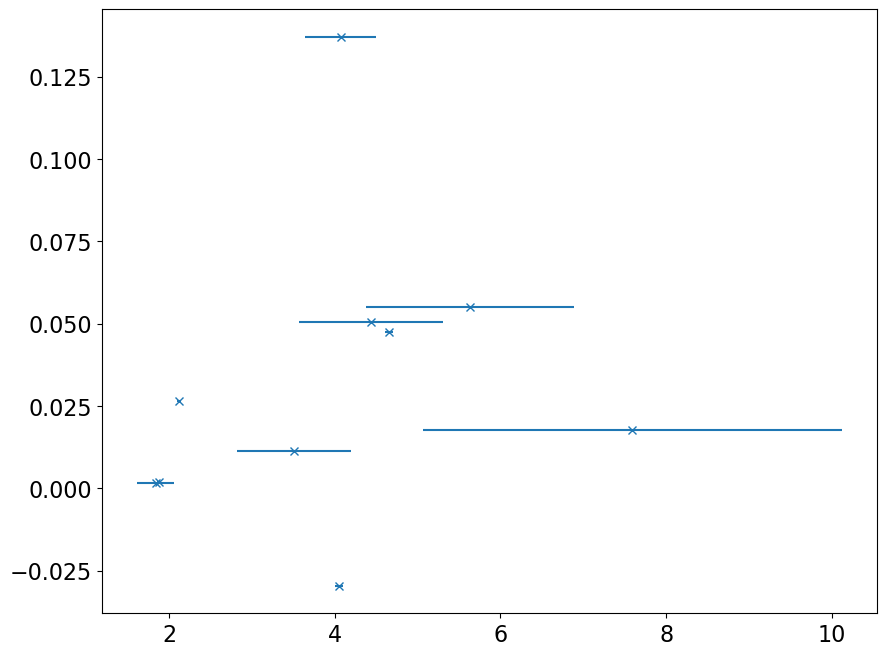

In [37]:
pl.errorbar(u.Quantity(wavelengths, u.um),
            u.Quantity([u.Quantity(x, u.Jy) for x in fluxes], u.Jy),
            xerr=widths, linestyle='none', marker='x')

# TODO: figure out where the green spitzer sources are

and what they are


Are they 4.5 micron excess?

5-8 micron dropout?

what?

In [38]:
bright_green_star_list = ['0604691', '0608824', '0611502', '0613733', '0611429', '0612623', '0613626', '0612695']

In [39]:
spitzer.add_index('SSTGC')

In [40]:
selind = spitzer.loc[bright_green_star_list[0]]
selind

<Row index=639>
 SSTGC    RAJ2000     DEJ2000     Jmag    Hmag    Ksmag   _3.6mag _4.5mag _5.8mag _8.0mag IRAC _2M               coordinates              
          'h:m:s'     'd:m:s'     mag     mag      mag      mag     mag     mag     mag                            deg,deg                
  str7     str11       str11    float32 float32  float32  float32 float32 float32 float32 str4 str2                SkyCoord               
------- ----------- ----------- ------- -------- -------- ------- ------- ------- ------- ---- ---- --------------------------------------
0604691 17 46 08.93 -28 41 22.5  15.819   14.663   12.374  10.953   8.864   8.285   8.895 IRAC   2M 266.53720833333324,-28.689583333333335

In [41]:
from astropy.coordinates import SkyCoord

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/quantity.py:502: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


Text(0.5, 1.0, '0604691')

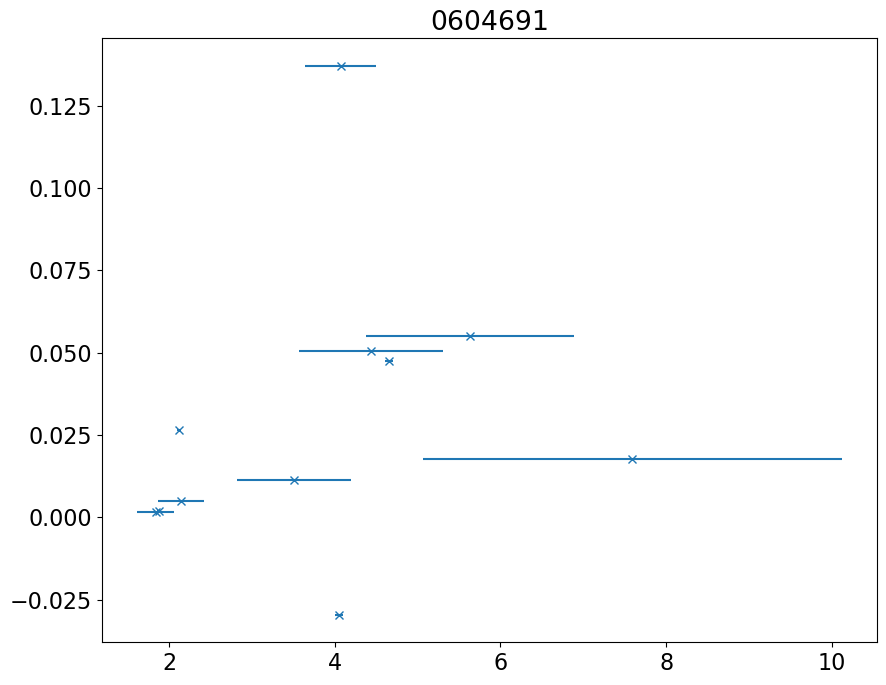

In [42]:
starid = bright_green_star_list[0]
selstar = spitzer.loc[starid]
coord = SkyCoord(selstar['RAJ2000'], selstar['DEJ2000'], frame='fk5', unit=(u.h, u.deg))
wavelengths, widths, fluxes, lims = make_sed(coord, basetable=basetable, radius=1*u.arcsec)
pl.errorbar(u.Quantity(wavelengths, u.um), u.Quantity([u.Quantity(x, u.Jy) for x in fluxes], u.Jy), xerr=widths, linestyle='none', marker='x')
pl.title(starid)

In [43]:
widths

[<Quantity 4262.85790239 Angstrom>,
 <Quantity 274.27440341 Angstrom>,
 <Quantity 535.40523943 Angstrom>,
 <Quantity 454.87184789 Angstrom>,
 <Quantity 236.68645057 Angstrom>,
 <Quantity 2250.8124937 Angstrom>,
 <Quantity 6836.18018646 Angstrom>,
 <Quantity 8649.92060205 Angstrom>,
 <Quantity 12561.17490202 Angstrom>,
 <Quantity 25288.49843082 Angstrom>,
 <Quantity 889.45988901 Angstrom>,
 <Quantity 870.63251373 Angstrom>,
 <Quantity 1542.51159452 Angstrom>,
 <Quantity 2674.06922586 Angstrom>,
 <Quantity 2793.83342778 Angstrom>]

In [44]:
ls -lhrt ../regions/green_spitzer_stars.reg

-rw-r--r-- 1 adamginsburg adamginsburg 1.2K Dec 23 18:59 ../regions/green_spitzer_stars.reg


In [45]:
vvvdr2[:2]

<Table length=1>
 RAJ2000    DEJ2000           iauname          mClass  Zmag3  e_Zmag3 Zperrbits  Ymag3  e_Ymag3 Yperrbits  Jmag3  e_Jmag3 Jperrbits  Hmag3  e_Hmag3 Hperrbits  Ksmag3 e_Ksmag3 Ksperrbits
   deg        deg                                       mag     mag               mag     mag               mag     mag               mag     mag               mag     mag              
 float64    float64            str24           int16  float32 float64   int32   float64 float64   int32   float64 float64   int32   float64 float64   int32   float64 float64    int32   
---------- ---------- ------------------------ ------ ------- ------- --------- ------- ------- --------- ------- ------- --------- ------- ------- --------- ------- -------- ----------
266.537139 -28.689561 VVV J174608.91-284122.41     -1      --      --         0      --      --         0      --      --         0      --      --         0  12.816    0.013          0

In [46]:
def starzoom_(x):
    starzoom(x)
    starzoom_spitzer(x)

In [47]:
greenstarregs = regions.Regions.read('../regions/green_spitzer_stars.reg')
greenstarregcenters = SkyCoord([gs.center for gs in greenstarregs])
inds_green, rev_inds, sep, sep3d = greenstarregcenters.search_around_sky(spitzer_crds, 2*u.arcsec)
inds_green_jw, sep_green_jw, sep_green_jw_3d = greenstarregcenters.match_to_catalog_sky(crds)
len(inds_green), len(greenstarregcenters), len(inds_green_jw), sep_green_jw.max().to(u.arcsec)

(1, 27, 27, <Angle 0.09699973 arcsec>)

In [48]:
greenstarregcenters[:2]

<SkyCoord (Galactic): (l, b) in deg
    [(0.2708176, 0.0294995), (0.2678877, 0.0213613)]>

In [49]:
basetable[inds_green_jw][:2]['mag_ab_f410m', 'flux_f410m', 'replaced_saturated_f410m', 'mag_ab_f405n', 'flux_f405n', 'replaced_saturated_f405n'].mask

<Table length=2>
mag_ab_f410m flux_f410m replaced_saturated_f410m mag_ab_f405n flux_f405n replaced_saturated_f405n
    bool        bool              bool               bool        bool              bool          
------------ ---------- ------------------------ ------------ ---------- ------------------------
        True       True                    False        False      False                    False
        True       True                    False        False      False                    False

In [50]:
basetable[inds_green_jw][:2]['mag_ab_f410m', 'flux_f410m', 'replaced_saturated_f410m', 'mag_ab_f405n', 'dflux_f405n', 'flux_f405n', 'replaced_saturated_f405n']

<Table length=2>
mag_ab_f410m flux_f410m replaced_saturated_f410m mag_ab_f405n dflux_f405n flux_f405n replaced_saturated_f405n
  float32     float32             bool             float32      float32    float32             bool          
------------ ---------- ------------------------ ------------ ----------- ---------- ------------------------
          --         --                     True    14.349453   7.6484385  6411.2764                    False
          --         --                     True    14.405948   7.9333634   6099.318                    False

In [51]:
import warnings

In [52]:
import sys, imp
sys.path.append(f'{basepath}/analysis/')
sys.path.append(f'{basepath}/reduction/')
import plot_tools
imp.reload(plot_tools)
from plot_tools import starzoom, make_sed, starzoom_spitzer

In [53]:
def triplot(ii):
    fig = pl.figure(figsize=(12, 12))
    ax = pl.subplot(2,1,1)
    try:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            selstar = spitzer[inds_green][ii]
            starid = selstar['SSTGC']
            #coord = SkyCoord(selstar['RAJ2000'], selstar['DEJ2000'], frame='fk5', unit=(u.h, u.deg))
            coord = greenstarregcenters[ii]
            wavelengths, widths, fluxes, lims = map(u.Quantity, make_sed(coord, basetable=basetable, radius=1*u.arcsec))
            lamflam = (fluxes * wavelengths.to(u.Hz, u.spectral())).to(u.erg/u.s/u.cm**2)
            lamflamlim = (lims * wavelengths.to(u.Hz, u.spectral())).to(u.erg/u.s/u.cm**2)
            pl.errorbar(u.Quantity(wavelengths, u.um), 
                        lamflam, #u.Quantity([u.Quantity(x, u.Jy) for x in fluxes], u.Jy),
                        xerr=[w/2 for w in widths], linestyle='none', marker='x')
            pl.errorbar(wavelengths.to(u.um), lamflamlim, xerr=[w/2 for w in widths], linestyle='none', marker='v')
            pl.title(f"SSTGC {starid}")
            pl.ylabel(r"$\lambda F_\lambda$ [erg s$^{-1}$ cm$^{-2}$]")
            pl.xlabel(r"Wavelength [$\mu$m]")
            pl.semilogy()
            axes = [pl.subplot(4, 6, ii) for ii in range(13, 20)]
            starzoom(coord, fig=fig, axes=axes)
            axes = [pl.subplot(4, 5, ii) for ii in range(16, 21)]
            starzoom_spitzer(coord, fig=fig, axes=axes)
            #return list(zip(wavelengths, widths))
    except Exception as ex:
        print(ex)

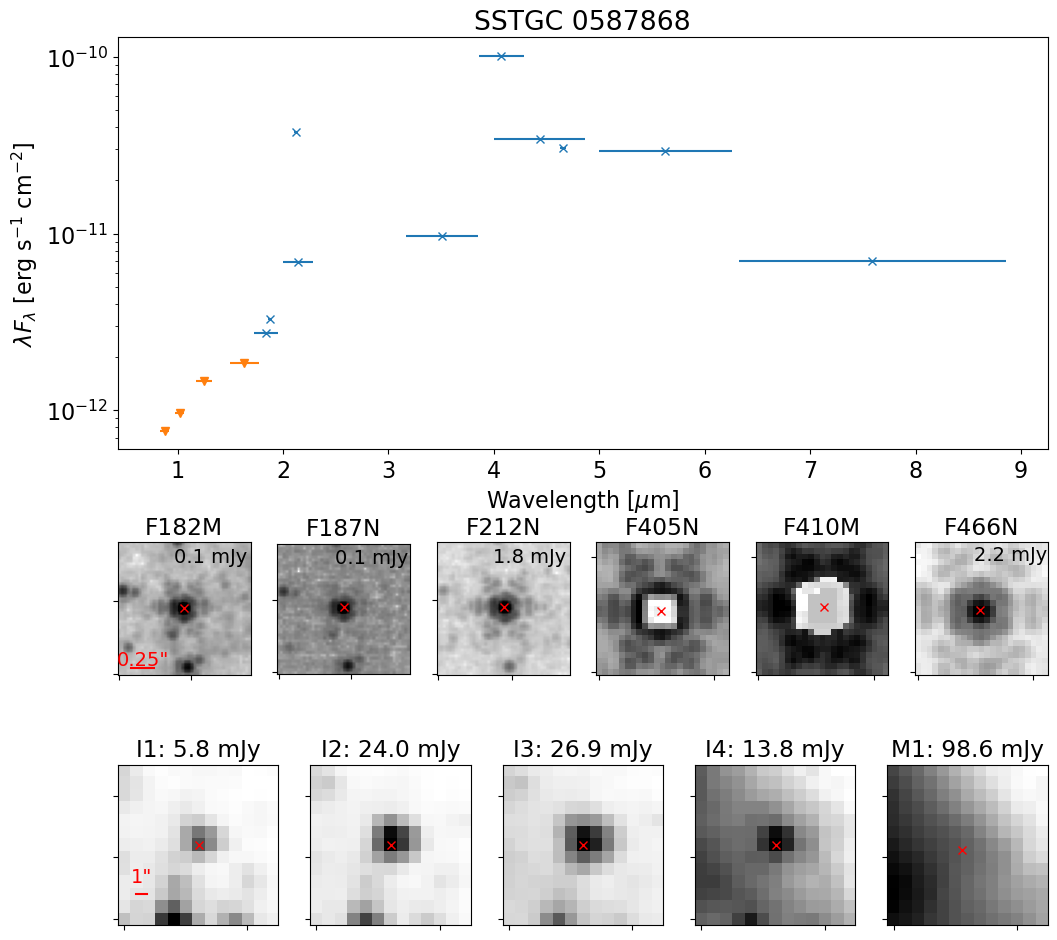

In [54]:
triplot(0)

index 1 out of range for table with length 1


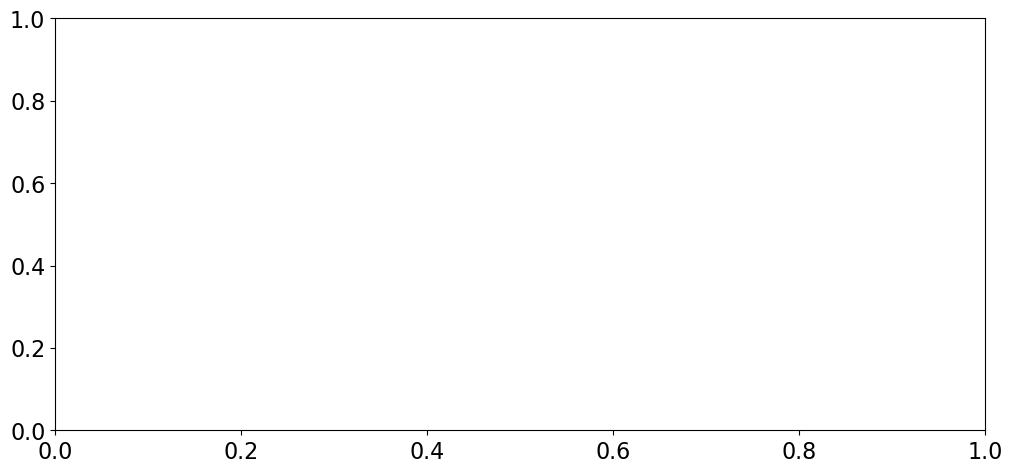

In [55]:
triplot(1)

index 2 out of range for table with length 1


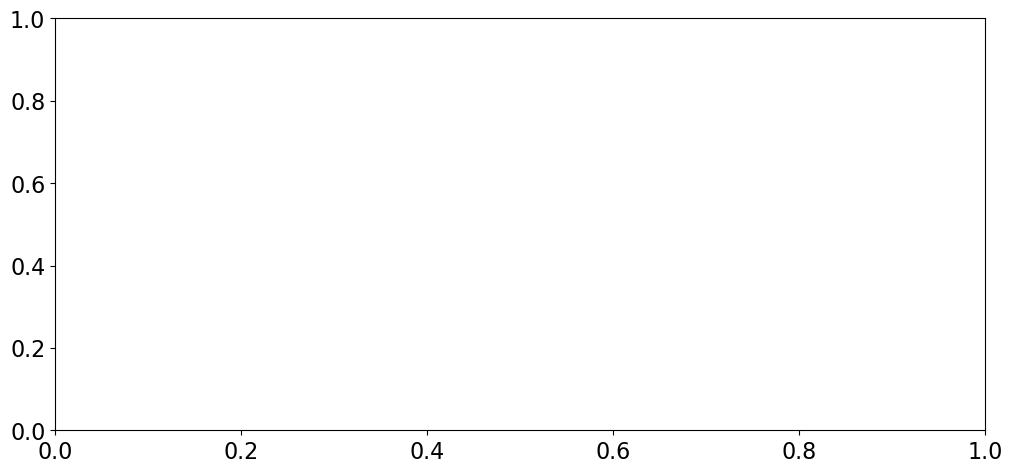

In [56]:
triplot(2)

index 3 out of range for table with length 1


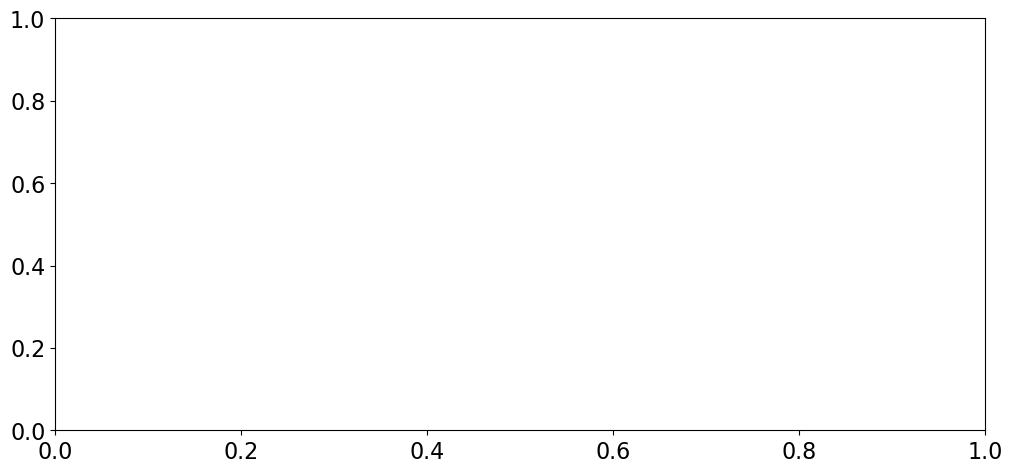

In [57]:
triplot(3)

index 4 out of range for table with length 1


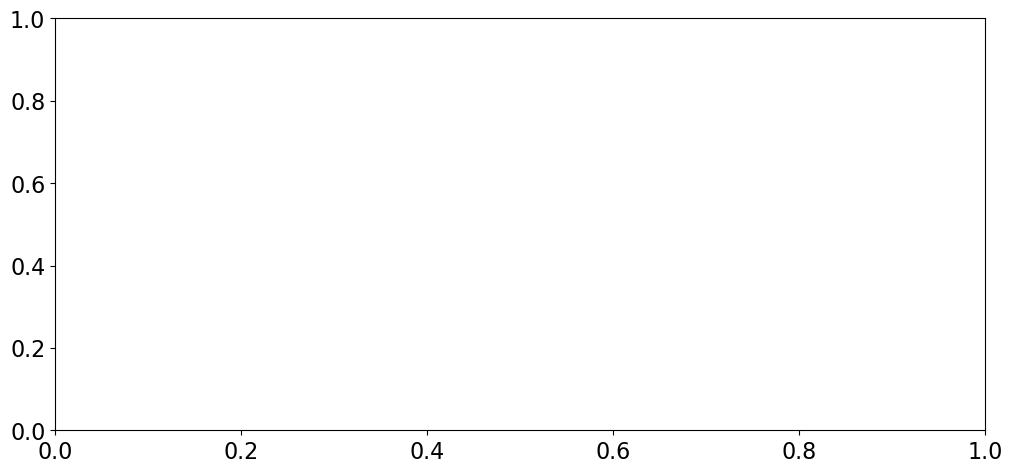

In [58]:
triplot(4)

index 5 out of range for table with length 1


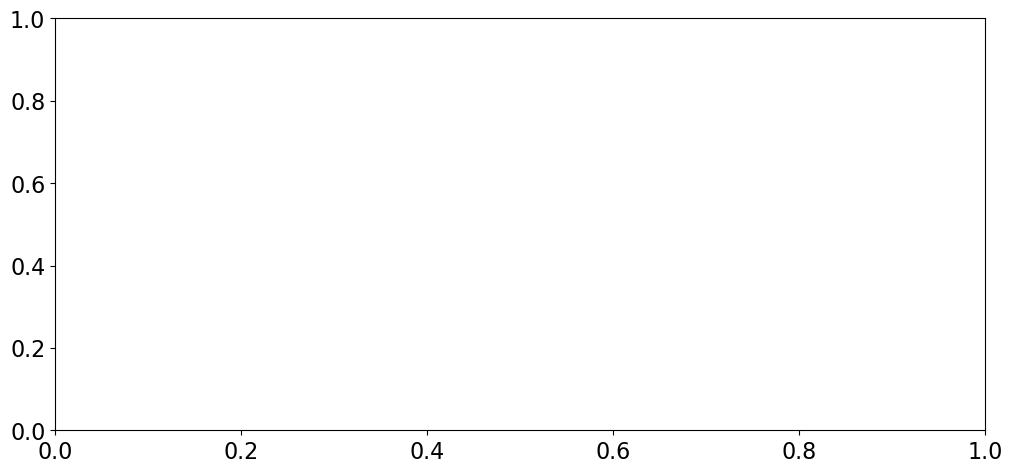

In [59]:
triplot(5)

index 6 out of range for table with length 1


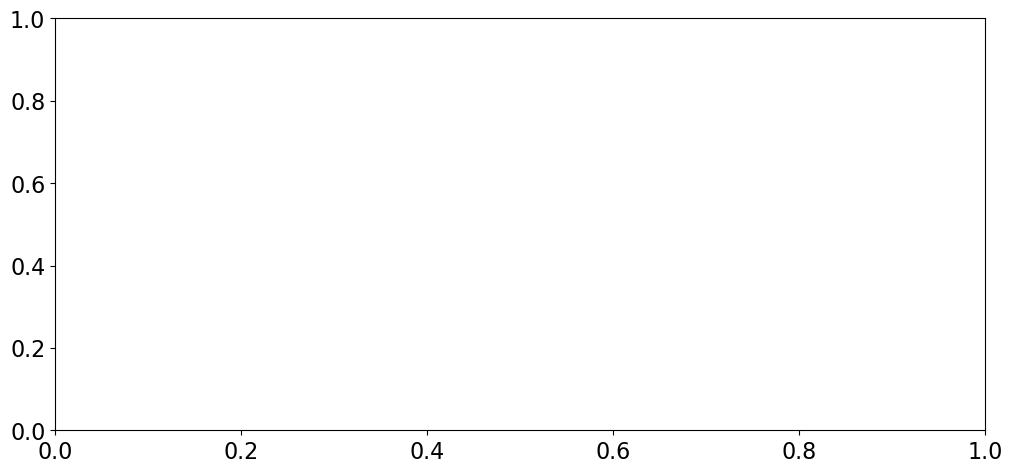

In [60]:
triplot(6)

index 7 out of range for table with length 1


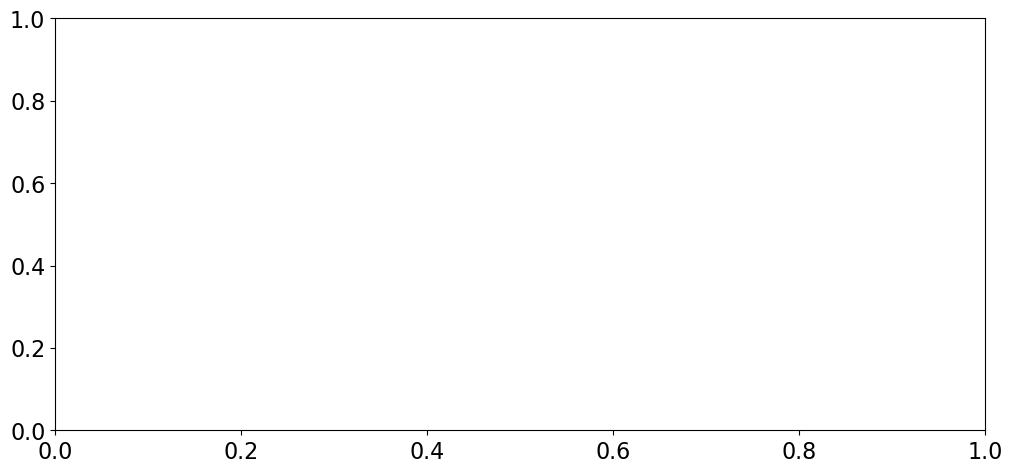

In [61]:
triplot(7)

index 8 out of range for table with length 1


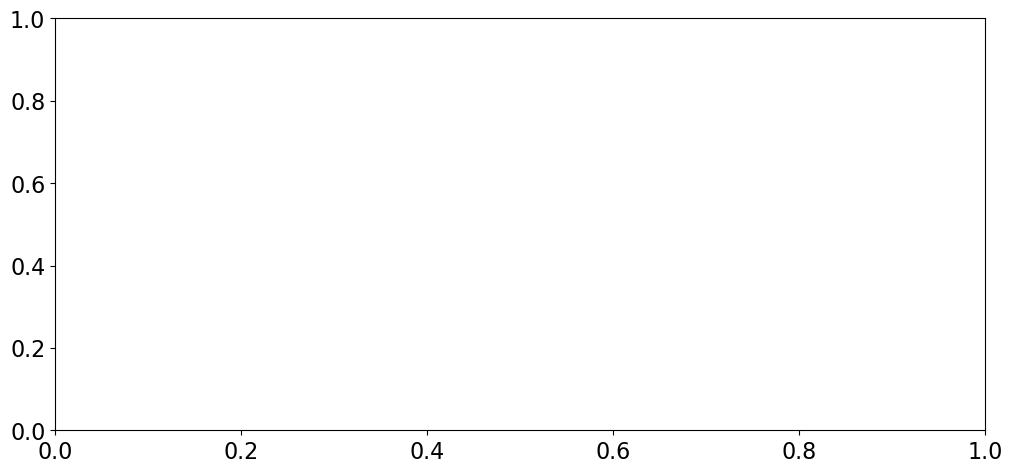

In [62]:
triplot(8)

index 9 out of range for table with length 1


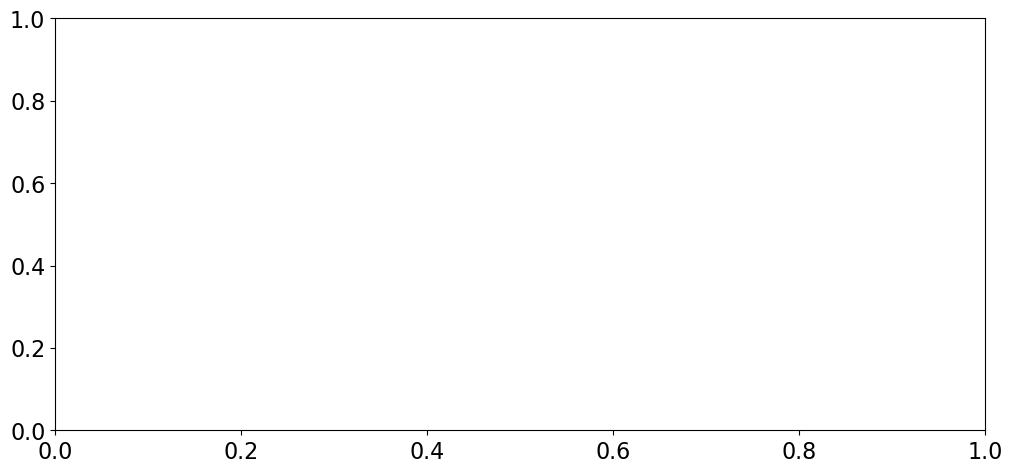

In [63]:
triplot(9)

index 10 out of range for table with length 1


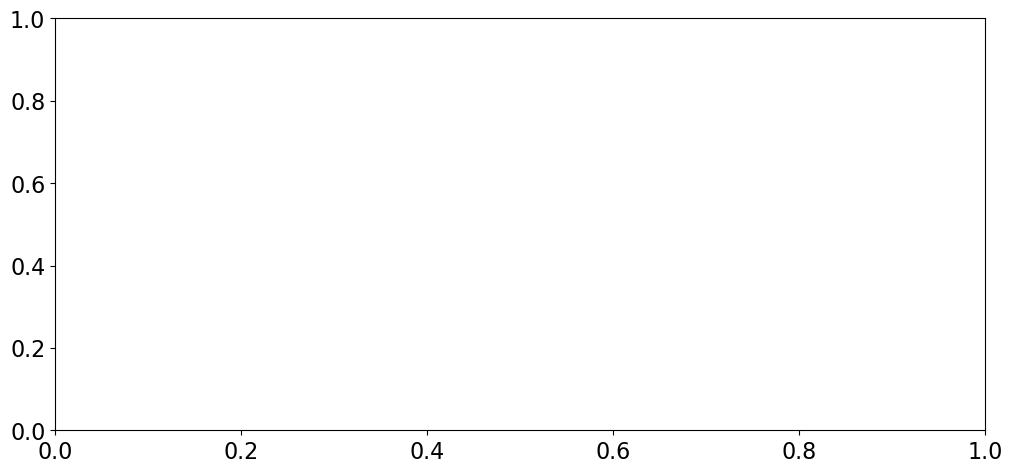

In [64]:
triplot(10)

index 11 out of range for table with length 1


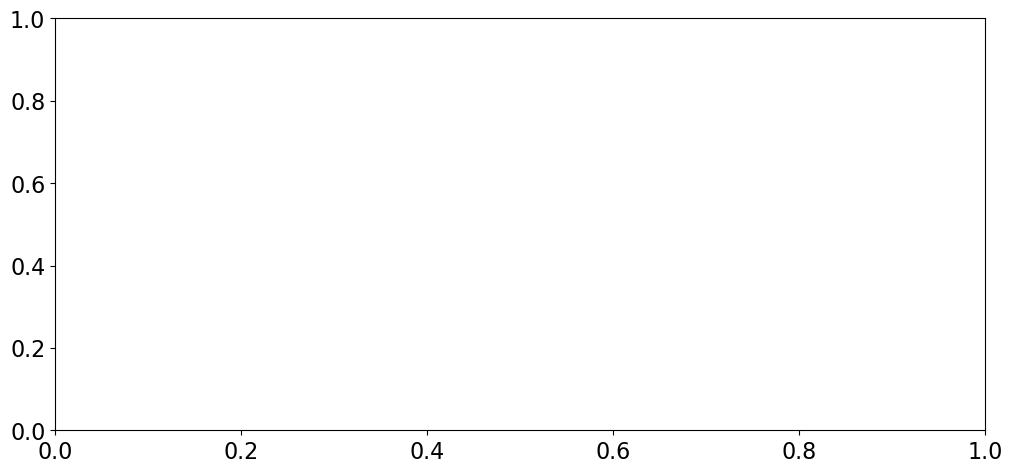

In [65]:
triplot(11)

index 12 out of range for table with length 1


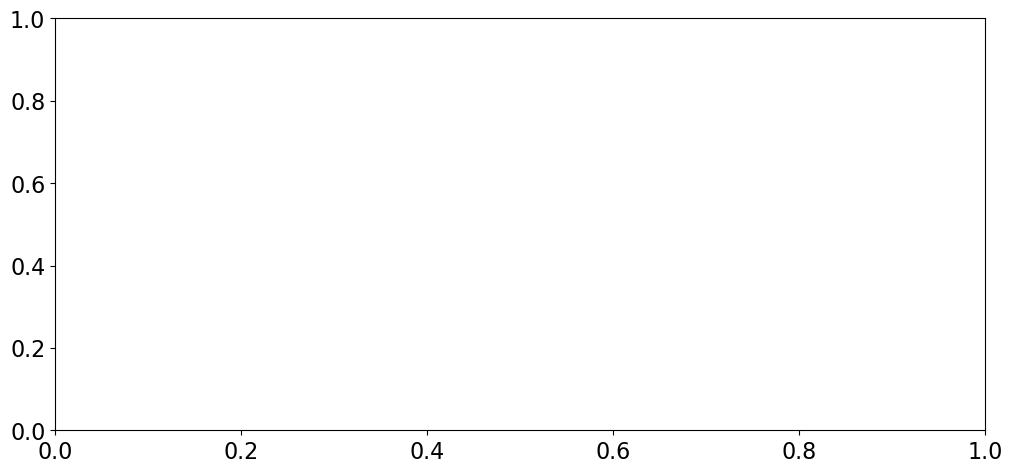

In [66]:
triplot(12)

index 13 out of range for table with length 1


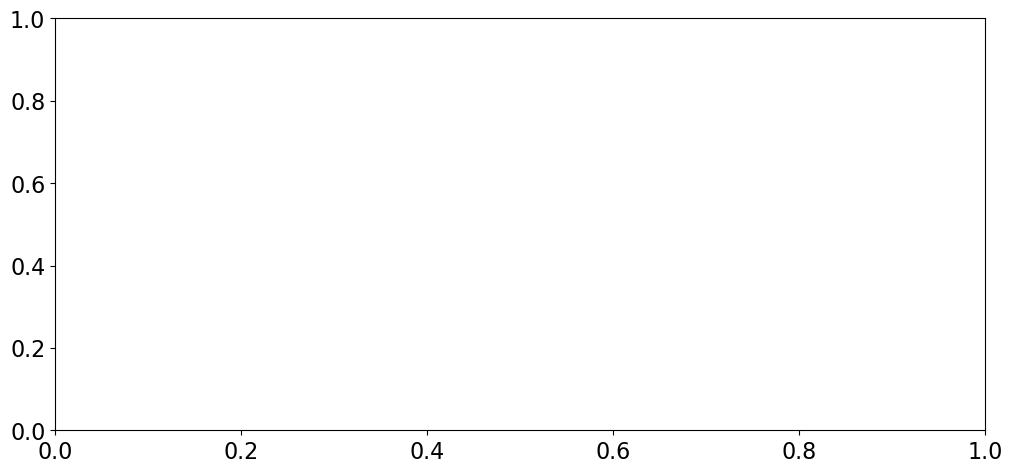

In [67]:
triplot(13)

index 14 out of range for table with length 1


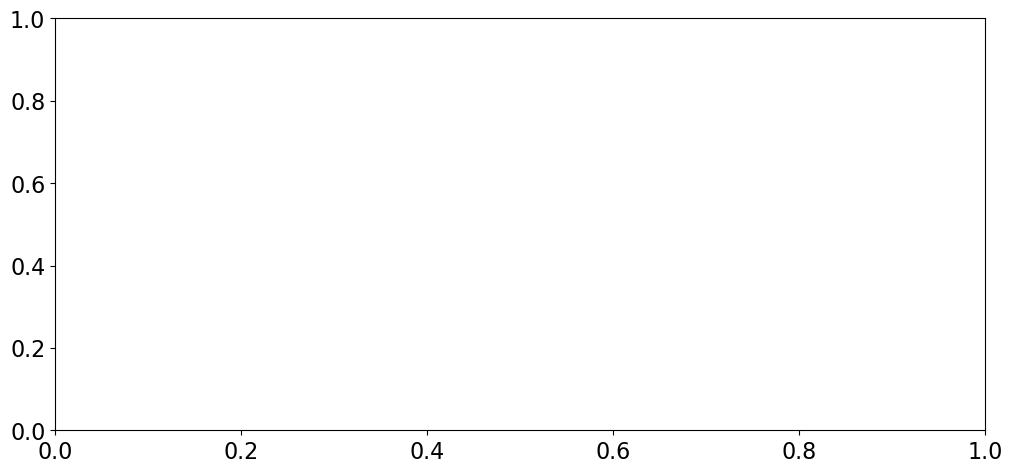

In [68]:
triplot(14)

index 15 out of range for table with length 1


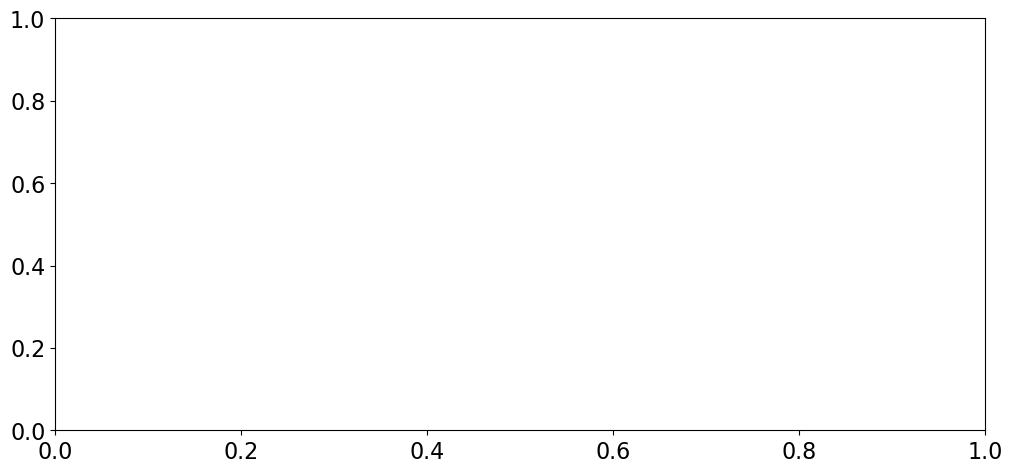

In [69]:
triplot(15)

index 16 out of range for table with length 1


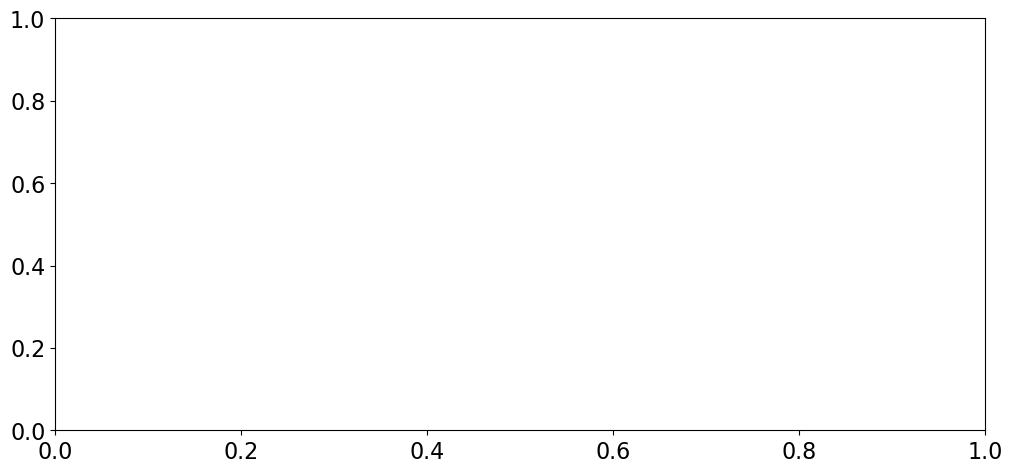

In [70]:
triplot(16)

index 17 out of range for table with length 1


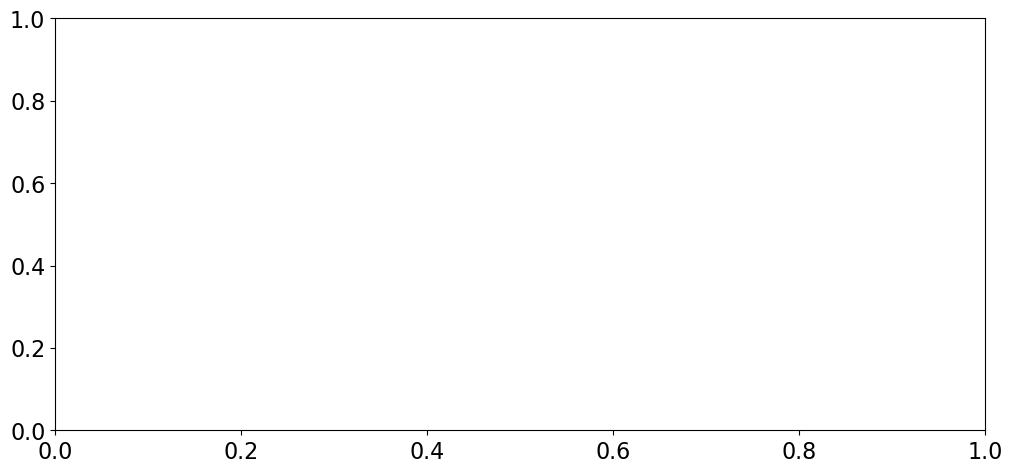

In [71]:
triplot(17)

index 18 out of range for table with length 1


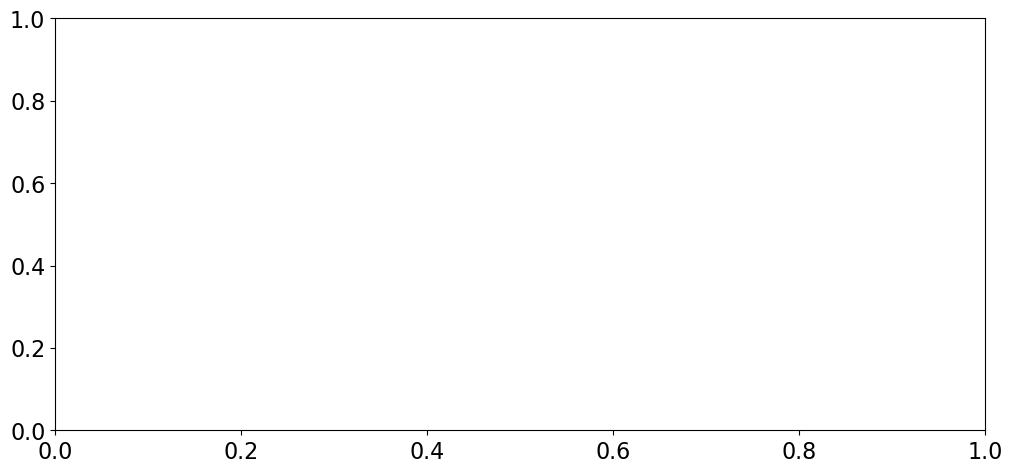

In [72]:
triplot(18)

index 19 out of range for table with length 1


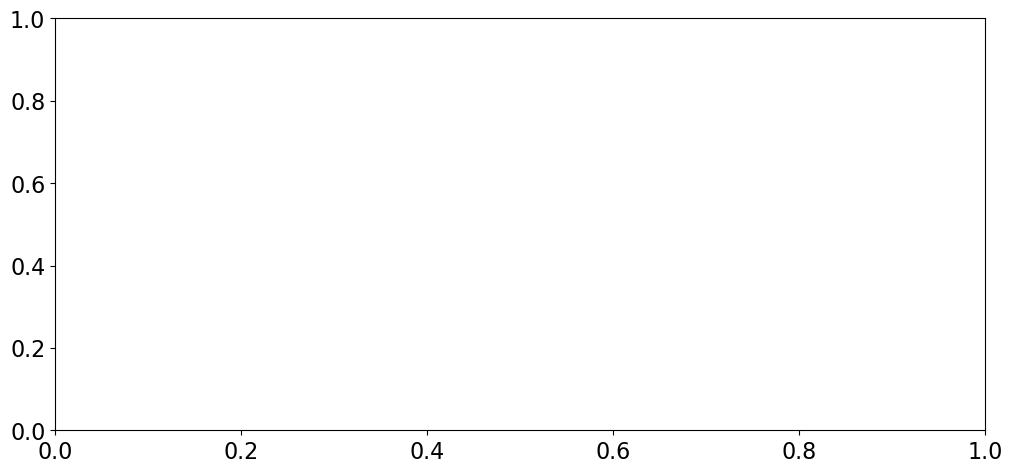

In [73]:
triplot(19)

index 20 out of range for table with length 1


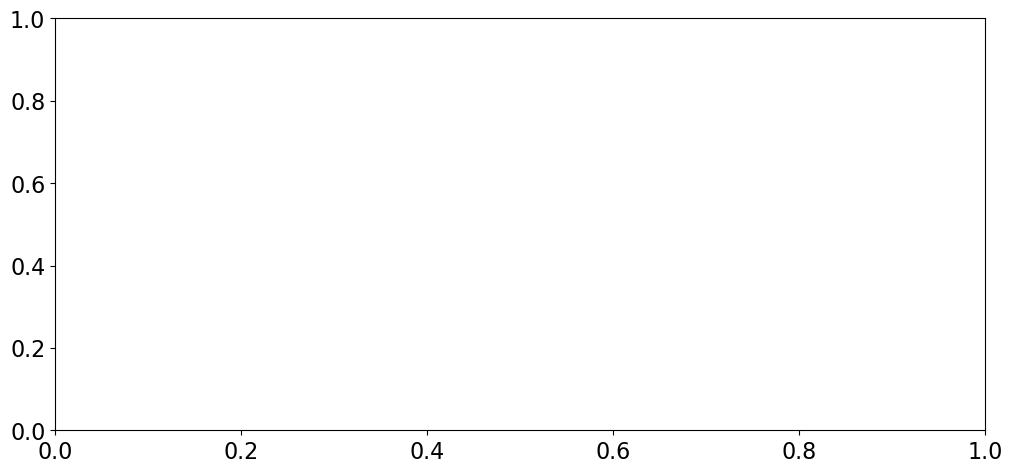

In [74]:
triplot(20)

index 21 out of range for table with length 1


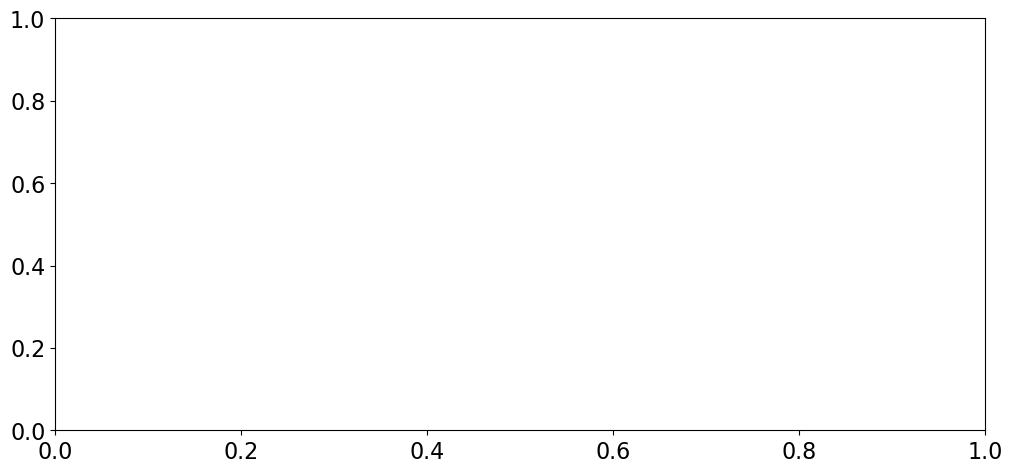

In [75]:
triplot(21)

index 22 out of range for table with length 1


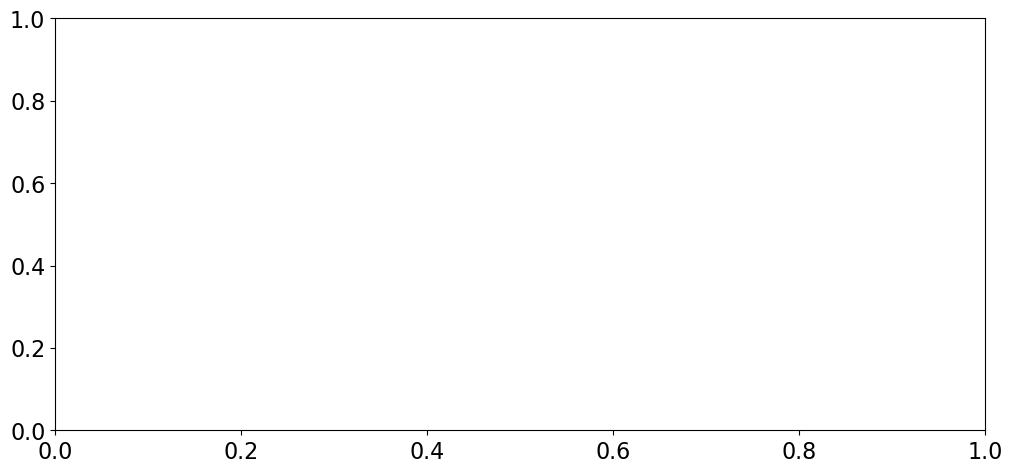

In [76]:
triplot(22)

index 23 out of range for table with length 1


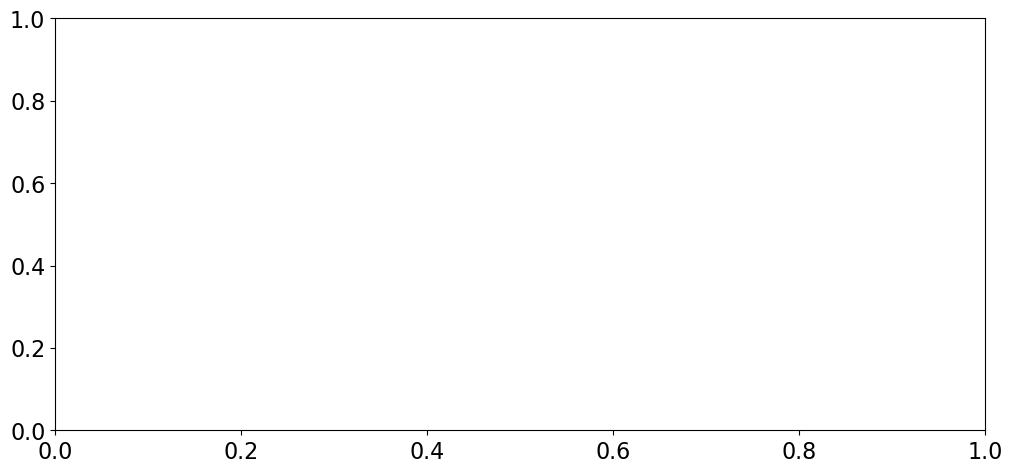

In [77]:
triplot(23)

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


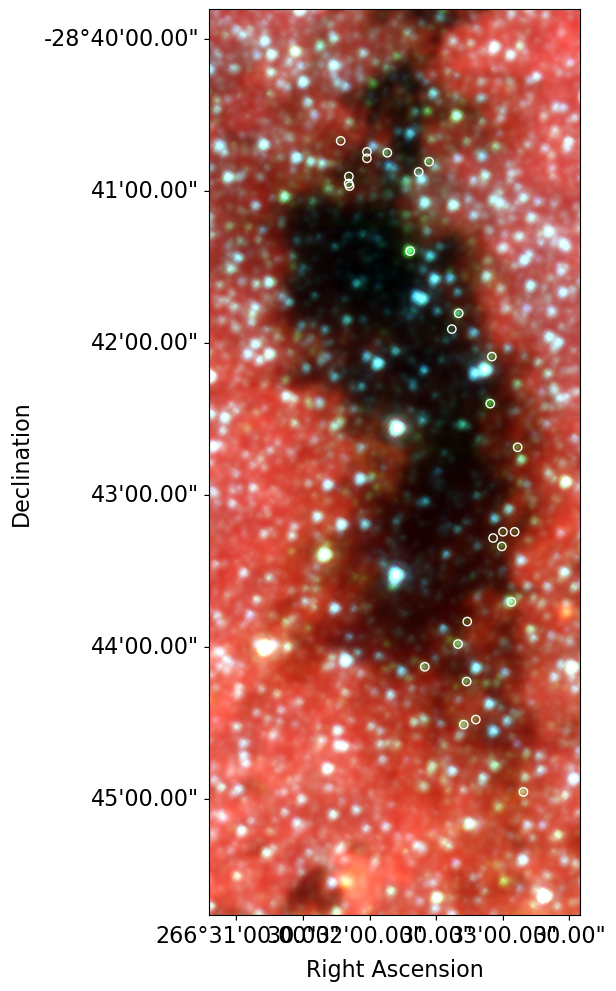

In [78]:
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
img_spitzer = np.array(PIL.Image.open(f'{basepath}/images/BrickSpitzer_RGB_I421.png'))[::-1,:,:]
wwi_spitzer_unflip = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_spitzer = img_spitzer.swapaxes(0,1)
wwi_spitzer = wwi_spitzer_unflip.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_spitzer)
ax.imshow(img_spitzer)
axlims = ax.axis()

xx,yy = wwi_spitzer.world_to_pixel(greenstarregcenters)
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='w', facecolors='none',
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);

#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('dd:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
#lon.set_ticks(spacing=30. * u.arcsec, color='red')
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')
#lon.set_ticklabel(color='red')
#lat.set_ticklabel(color='blue')
#lon.grid(color='red')
#lat.grid(color='blue')

ax.axis(axlims)

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

In [79]:
spitzer[:1]

<Table length=1>
 SSTGC    RAJ2000     DEJ2000     Jmag    Hmag    Ksmag   _3.6mag _4.5mag _5.8mag _8.0mag IRAC _2M           coordinates          
          'h:m:s'     'd:m:s'     mag     mag      mag      mag     mag     mag     mag                        deg,deg            
  str7     str11       str11    float32 float32  float32  float32 float32 float32 float32 str4 str2            SkyCoord           
------- ----------- ----------- ------- -------- -------- ------- ------- ------- ------- ---- ---- ------------------------------
0587868 17 46 02.85 -28 40 12.2  16.356   12.092   10.268   8.880   8.877   8.521   8.613 IRAC   2M 266.511875,-28.670055555555557

In [80]:
basetable[:2]

<Table length=2>
             skycoord_ref             sep_f410m id_f410m             skycoord_f410m                 x_f410m            y_f410m       ... flux_jy_405m410 mag_ab_405m410 flux_jy_182m187 mag_ab_182m187 flux_jy_187m182 mag_ab_187m182
               deg,deg                   deg                            deg,deg                                                      ...        Jy                             Jy                             Jy                     
               SkyCoord                float64   int64                  SkyCoord                    float64            float64       ...     float32        float32         float32        float32         float32        float32    
------------------------------------- --------- -------- ------------------------------------- ----------------- ------------------- ... --------------- -------------- --------------- -------------- --------------- --------------
266.51317153289136,-28.76195308689858       0.0        0 266.51317153289136,-28.76195308689858 46.28923411969844              -0.499 ...      -0.3472802             --              --       20.55277              --      18.408117
 266.5131719168592,-28.76171591885978       0.0        1  266.5131719168592,-28.76171591885978 59.83987374603748 -0.2750577926635742 ...              --      7.8828974              --      19.829252              --      19.307325

In [81]:
SvoFps.get_filter_list(facility="JWST", instrument="NIRCAM")[:1]

<Table length=1>
FilterProfileService      filterID     WavelengthUnit WavelengthUCD PhotSystem DetectorType  Band  ...    ZeroPoint    ZeroPointUnit   Mag0  ZeroPointType AsinhSoft                            TrasmissionCurve                          
                                                                                                   ...        Jy                                                                                                                          
       object              object          object         object      object      object    object ...     float64         object    float64     object     float64                                  object                               
-------------------- ----------------- -------------- ------------- ---------- ------------ ------ ... --------------- ------------- ------- ------------- --------- ---------------------------------------------------------------------
       ivo://svo/fps JWST/NIRCam.F070W       Angstrom         em.wl     NIRCam            1        ... 2768.4045696982            Jy     0.0        Pogson       0.0 http://svo2.cab.inta-csic.es//theory/fps/fps.php?ID=JWST/NIRCam.F070W

# not (yet) used

In [82]:
vvvdr2 = Vizier.query_region(coordinates=coord, width=width, height=height, catalog=['II/348/vvv2'])[0]
vvvdr2_crds = SkyCoord(vvvdr2['RAJ2000'], vvvdr2['DEJ2000'], frame='fk5')
idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(skycrds_cat, 0.2*u.arcsec)

twomass_crds = SkyCoord(twomass['RAJ2000'], twomass['DEJ2000'], frame='fk5')

In [83]:
spitzer[:10]

<Table length=10>
 SSTGC    RAJ2000     DEJ2000     Jmag    Hmag    Ksmag   _3.6mag _4.5mag _5.8mag _8.0mag IRAC _2M               coordinates              
          'h:m:s'     'd:m:s'     mag     mag      mag      mag     mag     mag     mag                            deg,deg                
  str7     str11       str11    float32 float32  float32  float32 float32 float32 float32 str4 str2                SkyCoord               
------- ----------- ----------- ------- -------- -------- ------- ------- ------- ------- ---- ---- --------------------------------------
0587868 17 46 02.85 -28 40 12.2  16.356   12.092   10.268   8.880   8.877   8.521   8.613 IRAC   2M         266.511875,-28.670055555555557
0587987 17 46 02.88 -28 40 56.9      --       --       --  11.862  11.750  11.650      -- IRAC   2M            266.512,-28.682472222222223
0588048 17 46 02.91 -28 41 10.7  16.354   13.242   11.082   9.990   9.987   9.204   8.947 IRAC   2M  266.5121249999999,-28.686305555555556
0588049 17 46 02.91 -28 41 20.5  15.151   13.292   11.662      --      --      --      -- IRAC   2M  266.5121249999999,-28.689027777777778
0588072 17 46 02.92 -28 40 51.0  16.289   13.174   11.558  10.455  10.306  10.410      -- IRAC   2M 266.51216666666664,-28.680833333333336
0588192 17 46 02.96 -28 40 34.4      --       --       --  11.804  11.215  10.388      -- IRAC   2M  266.5123333333333,-28.676222222222222
0588205 17 46 02.97 -28 41 17.4  15.686   13.187   12.083  10.381  10.213   9.779      -- IRAC   2M 266.51237499999996,-28.688166666666667
0588263 17 46 02.99 -28 42 13.3  15.949   11.427    9.056   7.284   7.041   6.496   6.504 IRAC   2M  266.5124583333333,-28.703694444444444
0588346 17 46 03.02 -28 42 47.6  17.364   13.131   11.479  10.095      --      --      -- IRAC   2M   266.5125833333333,-28.71322222222222
0588403 17 46 03.04 -28 39 48.7  16.565   13.542   12.506  11.155  11.263  10.735      -- IRAC   2M  266.5126666666666,-28.663527777777777

# An2011 Vizier

In [84]:
an2011 = Vizier(row_limit=500).get_catalogs(['J/ApJ/736/133/table1'])[0]

In [85]:
an2011crds = SkyCoord(an2011['RAJ2000'], an2011['DEJ2000'], frame='fk5', unit=(u.h, u.deg))

In [86]:
an2011[wwi_spitzer.footprint_contains(an2011crds)]

<Table length=3>
SSTGC   Y     RAJ2000     DEJ2000      Date      Us  F02  S06  Y09  f_Y09 YSOcat
              'h:m:s'     'd:m:s'    'Y:M:D'                                    
int32  str1    str11       str11      str10     str5 str3 str3 str3  str1 int16 
------ ---- ----------- ----------- ---------- ----- ---- ---- ---- ----- ------
600274      17 46 07.39 -28 45 32.0 2008-05-01    no                           0
618018    Y 17 46 13.81 -28 43 44.5 2008-05-01 maybe  yes                      1
619522    Y 17 46 14.33 -28 43 18.4 2008-05-01 maybe                           0

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


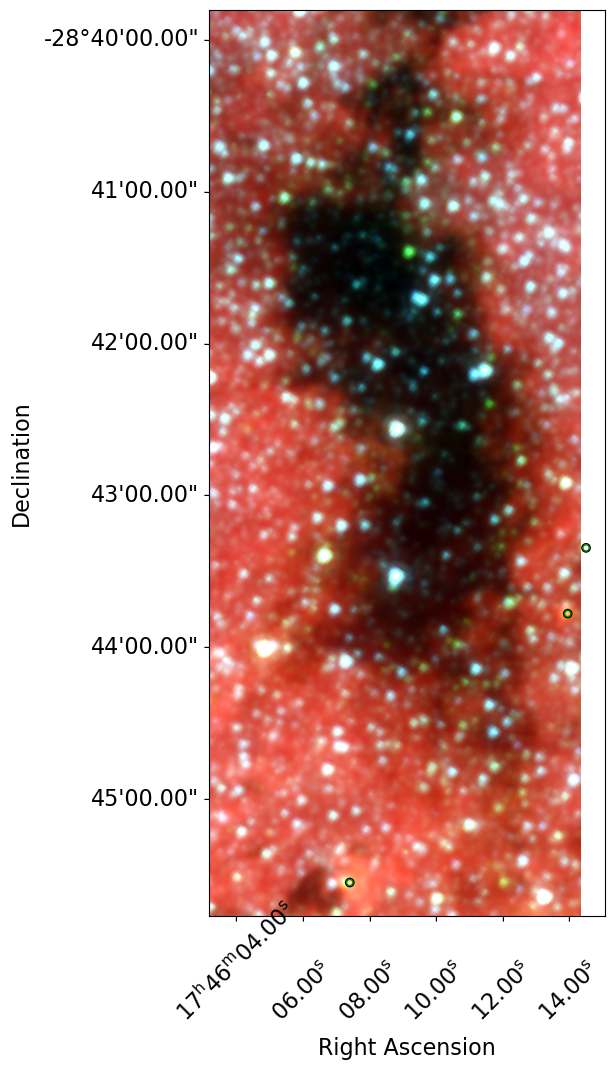

In [87]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
img_spitzer = np.array(PIL.Image.open(f'{basepath}/images/BrickSpitzer_RGB_I421.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_spitzer = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_spitzer = img_spitzer.swapaxes(0,1)
wwi_spitzer = wwi_spitzer.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_spitzer)
ax.imshow(img_spitzer)
axlims = ax.axis()

xx,yy = wwi_spitzer.world_to_pixel(an2011crds[wwi_spitzer.footprint_contains(an2011crds)])
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='black', facecolors='none',
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);
ax.scatter(
    xx,yy,
    s=20,
    marker='o', edgecolors='g', facecolors='none',
);
#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('hh:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
lon.set_ticks(spacing=30. * u.arcsec)
lon.set_ticklabel(rotation=45, pad=60)
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')



#ax.axis(axlims)

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

# make CCDs/CMDs highlighting the green stars

also show the stars with nondetections in one or more bands

In [88]:
inds_green, rev_inds, sep, sep3d = greenstarregcenters.search_around_sky(spitzer_crds, 2*u.arcsec)

(array([ 2.,  3.,  9., 16., 61., 50., 47., 17.,  4.,  1.]),
 array([ 5.028    ,  5.7058   ,  6.3835998,  7.0614   ,  7.7391996,
         8.417    ,  9.0948   ,  9.7726   , 10.450399 , 11.1282   ,
        11.806    ], dtype=float32),
 <BarContainer object of 10 artists>)

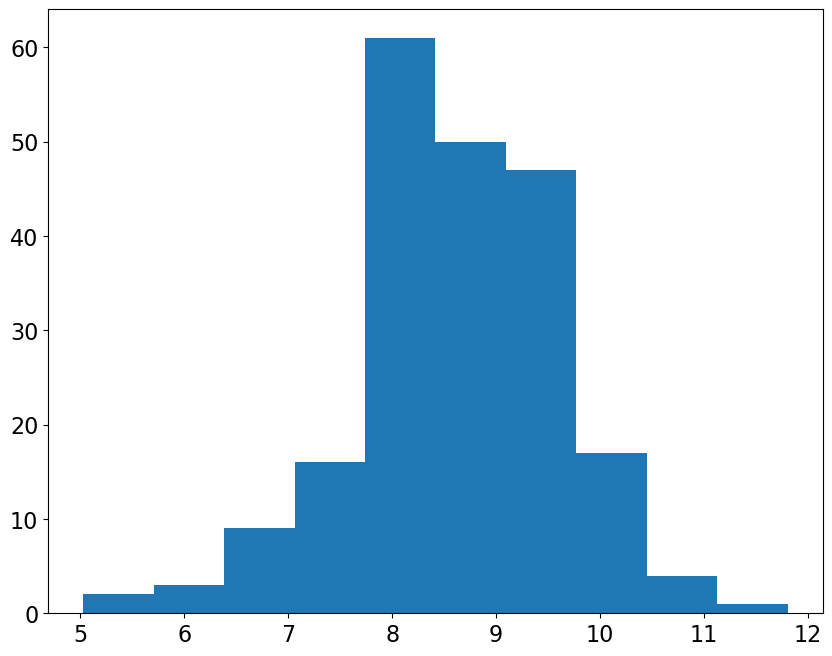

In [89]:
pl.hist(spitzer['_8.0mag'])

In [90]:
i4lim = np.nanpercentile(np.array(spitzer['_8.0mag']), 99)
i3lim = np.nanpercentile(np.array(spitzer['_5.8mag']), 99)
i2lim = np.nanpercentile(np.array(spitzer['_4.5mag']), 99)
i1lim = np.nanpercentile(np.array(spitzer['_3.6mag']), 99)
i1lim, i2lim, i3lim, i4lim

(13.594460010528564, 13.034479751586915, 12.056260299682616, 10.70722972869873)

In [91]:
spitzer[inds_green]

<Table length=1>
 SSTGC    RAJ2000     DEJ2000     Jmag    Hmag    Ksmag   _3.6mag _4.5mag _5.8mag _8.0mag IRAC _2M           coordinates          
          'h:m:s'     'd:m:s'     mag     mag      mag      mag     mag     mag     mag                        deg,deg            
  str7     str11       str11    float32 float32  float32  float32 float32 float32 float32 str4 str2            SkyCoord           
------- ----------- ----------- ------- -------- -------- ------- ------- ------- ------- ---- ---- ------------------------------
0587868 17 46 02.85 -28 40 12.2  16.356   12.092   10.268   8.880   8.877   8.521   8.613 IRAC   2M 266.511875,-28.670055555555557

Text(0, 0.5, 'I2-I4')

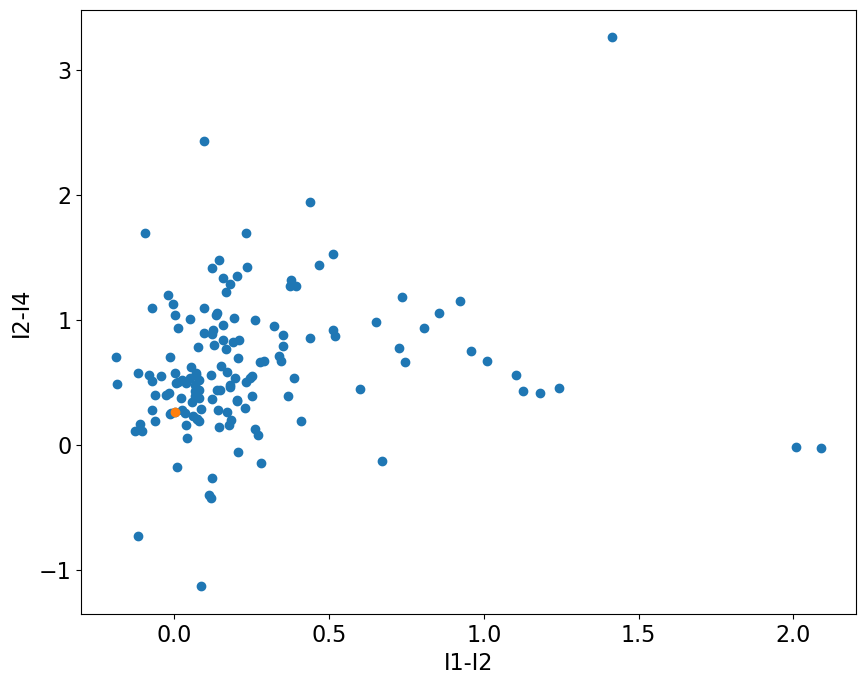

In [92]:
pl.scatter(spitzer['_3.6mag'] - spitzer['_4.5mag'],  spitzer['_4.5mag'] - spitzer['_8.0mag'])
pl.scatter(spitzer['_3.6mag'][inds_green] - spitzer['_4.5mag'][inds_green],  spitzer['_4.5mag'][inds_green] - spitzer['_8.0mag'][inds_green])
pl.xlabel("I1-I2")
pl.ylabel("I2-I4")

From SED inspection, done below, it is common to have I3 detection but I4 nondetection

In [93]:
green_spitzer = (np.array(spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0.5) |
                 (np.array(spitzer['_4.5mag'] - spitzer['_5.8mag'] < 0.0)))
green_nored = np.array((spitzer['_4.5mag'] < i2lim-1) & (spitzer['_8.0mag'].mask))
redI1I2 = ((np.array(spitzer['_3.6mag'] - spitzer['_4.5mag'] > 1)) |
           (np.array(spitzer['_3.6mag'].mask & ~spitzer['_4.5mag'].mask)))
reddish_i1i2_spitzer_and_greeni2i4 = (redI1I2 &
                                      (green_nored | green_spitzer)
                                      & wwi_spitzer_unflip.footprint_contains(spitzer_crds)
                                     )
reddish_i1i2_spitzer_and_greeni2i4.sum()

77

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 1169

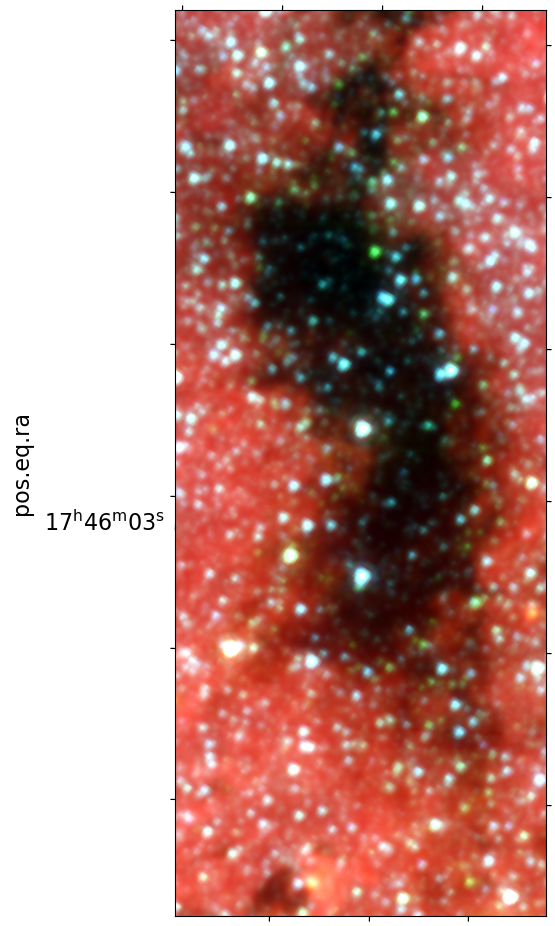

In [94]:
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
img_spitzer = np.array(PIL.Image.open(f'{basepath}/images/BrickSpitzer_RGB_I421.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_spitzer_unflip = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_spitzer = img_spitzer.swapaxes(0,1)
wwi_spitzer = wwi_spitzer_unflip.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_spitzer)
ax.imshow(img_spitzer)
axlims = ax.axis()

green_spitzer = np.array(spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0.)
green_nored = np.array((spitzer['_4.5mag'] < 10) & (spitzer['_8.0mag'].mask))
xx,yy = wwi_spitzer.world_to_pixel(spitzer_crds[reddish_i1i2_spitzer_and_greeni2i4])
print("These #'s should be equal:", reddish_i1i2_spitzer_and_greeni2i4.sum(), len(xx))
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='lime', facecolors='none',
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);
xx,yy = wwi_spitzer.world_to_pixel(greenstarregcenters)
ax.scatter(xx, yy, marker='x', s=4, color='lime')
#xx,yy = wwi_spitzer.world_to_pixel(spitzer_crds[green_nored])
#ax.scatter(
#    xx,yy,
#    marker='o', edgecolors='b', facecolors='none',
#);
redi1i2_spitzer = (spitzer['_3.6mag'] - spitzer['_4.5mag'] > 1.75)# | ((10 < spitzer['_4.5mag']) & (spitzer['_4.5mag'] < 15) & (spitzer['_8.0mag'].mask))
xx,yy = wwi_spitzer.world_to_pixel(spitzer_crds[redi1i2_spitzer])
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='w', facecolors='none',
s=15,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);
#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('dd:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
#lon.set_ticks(spacing=30. * u.arcsec, color='red')
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')
#lon.set_ticklabel(color='red')
#lat.set_ticklabel(color='blue')
#lon.grid(color='red')
#lat.grid(color='blue')

ax.axis(axlims)

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

In [ ]:
(spitzer['_3.6mag'].mask & ~spitzer['_4.5mag'].mask).sum()

In [ ]:
(~spitzer['_3.6mag'].mask & spitzer['_4.5mag'].mask).sum()

In [ ]:
mag8mask = spitzer['_8.0mag'].mask
(reddish_i1i2_spitzer_and_greeni2i4 & mag8mask).sum()

In [ ]:
i4lim = np.nanpercentile(np.array(spitzer['_8.0mag']), 99)
pl.scatter(spitzer['_4.5mag'] - spitzer['_8.0mag'],  spitzer['_4.5mag'], color='orange')
#pl.scatter(spitzer['_4.5mag'][spitzer['_8.0mag'].mask] - i4lim,  spitzer['_4.5mag'][spitzer['_8.0mag'].mask])

mag8mask = spitzer['_8.0mag'].mask
greensrcmask = np.zeros_like(mag8mask, dtype='bool')
greensrcmask[inds_green] = True
pl.scatter(spitzer['_4.5mag'][inds_green] - spitzer['_8.0mag'][inds_green], 
           spitzer['_4.5mag'][inds_green], color='g')
pl.scatter(spitzer['_4.5mag'][greensrcmask & mag8mask] - i4lim,
           spitzer['_4.5mag'][greensrcmask & mag8mask],
           marker='<',
           color='g',
          )
#pl.scatter((spitzer['_4.5mag'] - spitzer['_8.0mag'])[reddish_i1i2_spitzer_and_greeni2i4], 
#           spitzer['_4.5mag'][reddish_i1i2_spitzer_and_greeni2i4],
#          color='r')
#pl.scatter(spitzer['_4.5mag'][reddish_i1i2_spitzer_and_greeni2i4 & mag8mask] - i4lim,
#           spitzer['_4.5mag'][reddish_i1i2_spitzer_and_greeni2i4 & mag8mask],
#           marker='<',
#           color='r',
#          )


pl.xlabel("I2-I4")
pl.ylabel("I2")
pl.ylim(pl.ylim()[::-1])

In [ ]:
pl.scatter(spitzer['_4.5mag'] - spitzer['_5.8mag'],  spitzer['_4.5mag'], color='orange')
#pl.scatter(spitzer['_4.5mag'][spitzer['_8.0mag'].mask] - i4lim,  spitzer['_4.5mag'][spitzer['_8.0mag'].mask])

magi3mask = spitzer['_5.8mag'].mask
greensrcmask = np.zeros_like(magi3mask, dtype='bool')
greensrcmask[inds_green] = True
pl.scatter(spitzer['_4.5mag'][inds_green] - spitzer['_5.8mag'][inds_green],  spitzer['_4.5mag'][inds_green],
           color='g')
pl.scatter(spitzer['_4.5mag'][greensrcmask & magi3mask] - i3lim,
           spitzer['_4.5mag'][greensrcmask & magi3mask],
           marker='<',
           color='g'
          )
#pl.scatter((spitzer['_4.5mag'] - spitzer['_5.8mag'])[reddish_i1i2_spitzer_and_greeni2i4], 
#           spitzer['_4.5mag'][reddish_i1i2_spitzer_and_greeni2i4],
#          color='r')
#pl.scatter(spitzer['_4.5mag'][reddish_i1i2_spitzer_and_greeni2i4 & mag8mask] - i3lim,
#           spitzer['_4.5mag'][reddish_i1i2_spitzer_and_greeni2i4 & mag8mask],
#           marker='<',
#          )


pl.xlabel("I2-I3")
pl.ylabel("I2")
pl.ylim(pl.ylim()[::-1])

In [ ]:
pl.scatter(spitzer['_3.6mag'] - spitzer['_5.8mag'],  spitzer['_4.5mag'] - spitzer['_8.0mag'])
pl.scatter(spitzer['_3.6mag'][inds_green] - spitzer['_5.8mag'][inds_green],  spitzer['_4.5mag'][inds_green] - spitzer['_8.0mag'][inds_green])

pl.xlabel("I1-I3")
pl.ylabel("I2-I4")

# SEDs again

In [ ]:
import sys, imp
sys.path.append(f'{basepath}/analysis/')
import plot_tools
imp.reload(plot_tools)
from plot_tools import starzoom, make_sed

In [ ]:
selstar = spitzer[reddish_i1i2_spitzer_and_greeni2i4][0]
coord = SkyCoord(selstar['RAJ2000'], selstar['DEJ2000'], frame='fk5', unit=(u.h, u.deg))
wavelengths, widths, fluxes, lims = make_sed(coord, basetable=basetable, radius=1*u.arcsec)
pl.errorbar(u.Quantity(wavelengths, u.um), u.Quantity([u.Quantity(x, u.Jy) for x in fluxes], u.Jy),
            xerr=[w/2 for w in widths], linestyle='none', marker='x')
pl.title(starid)
starzoom_(coord)

## Exploration of saturated photometry so I can merge it


This is just doodling at the terminal and can be ignored, but I didn't want to delete it...

In [ ]:
filtername ='f410m'
satstar_cat_fn = f'{basepath}/{filtername.upper()}/pipeline/jw02221-o001_t001_nircam_clear-{filtername}-merged_i2d_satstar_catalog.fits'
satstar_cat = Table.read(satstar_cat_fn)
satstar_coords = satstar_cat['skycoord_fit']


In [ ]:
coord = greenstarregcenters[0]
radius = 0.2*u.arcsec
skycrds_cat = basetable['skycoord_f410m']
idx = coord.separation(skycrds_cat) < radius
print(np.where(idx))
idxsat = coord.separation(satstar_coords) < radius
print(np.where(idxsat), coord.separation(satstar_coords)[idxsat].to(u.arcsec))
basetable[idx]

In [ ]:
satstar_cat[152]